# BG/NBD Model in PyMC

In this notebook we show how to port the BG/NBD model from the the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) (developed mainly by [Cameron Davidson-Pilon](https://github.com/CamDavidsonPilon)) package to [`pymc`](https://github.com/pymc-devs/pymc). The BG/NBD model, introduced in the seminal paper ["Counting Your Customers" the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf) by Peter S. Fader, Bruce G. S. Hardie and Ka Lok Lee in 2005, is used to
> *predict future purchasing patterns, which can then serve as an input into “lifetime value” calculations, in the “non-contractual” setting (i.e., where the opportunities for transactions are continuous and the time at which customers become inactive is unobserved).*

Why to port the BG/NBD model to [`pymc`](https://github.com/pymc-devs/pymc)?

1. The [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package is currently in "maintenance-mode", so we do not expect it to be further developed. In addition, I am not aware of other python implementation (the R community has more options available)
2. This current implementation does not allow for time-invariant external covariates even though is an easy extension an shown in the paper [Incorporating Time-Invariant Covariates into the Pareto/NBD and BG/NBD Models](http://brucehardie.com/notes/019/time_invariant_covariates.pdf) by Peter S. Fader and Bruce G. S. Hardie. There is actually an [open PR](https://github.com/CamDavidsonPilon/lifetimes/pull/342) to att his feature into the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package, but it is highly unlikely to be merged. Hence, as in practice time-invariant covariates could further segment user purchase patterns, writing this model explicitly can allow for more flexibility.
3. We can take advantage of the powerful bayesian machinery to have better uncertainty estimation and the possibility to use extend the base BG/NBD model to more complex ones, e.g. hierarchical models.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifetimes.datasets import load_cdnow_summary
from lifetimes import BetaGeoFitter
import pymc as pm
import pymc.sampling_jax
from scipy.special import expit, hyp2f1
import aesara.tensor as at

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

seed = sum(map(ord, "juanitorduz"))
rng = np.random.default_rng(seed)

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Load Data

We are going to use an existing data set from the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package documentation, see [here](https://lifetimes.readthedocs.io/en/latest/Quickstart.html).

In [2]:
data_df = load_cdnow_summary(index_col=[0])

n_obs = data_df.shape[0]

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2357 entries, 1 to 2357
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frequency  2357 non-null   int64  
 1   recency    2357 non-null   float64
 2   T          2357 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 73.7 KB


From the package's documentation:

> - `frequency`: Number of repeat purchases the customer has made. More precisely, It’s the count of time periods the customer had a purchase in.
> - `T`: Age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
> - `recency`: Age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase.

In [3]:
data_df.head(10)

frequency 
 recency 
 T 
 
 
 ID 
 
 
 
 
 
 
 
 1 
 2 
 30.43 
 38.86 
 
 
 2 
 1 
 1.71 
 38.86 
 
 
 3 
 0 
 0.00 
 38.86 
 
 
 4 
 0 
 0.00 
 38.86 
 
 
 5 
 0 
 0.00 
 38.86 
 
 
 6 
 7 
 29.43 
 38.86 
 
 
 7 
 1 
 5.00 
 38.86 
 
 
 8 
 0 
 0.00 
 38.86 
 
 
 9 
 2 
 35.71 
 38.86 
 
 
 10 
 0 
 0.00 
 38.86

Let us extract the data as arrays and recover the notation from the original papers.

In [4]:
n = data_df.shape[0]
x = data_df["frequency"].to_numpy()
t_x = data_df["recency"].to_numpy()
T = data_df["T"].to_numpy()

# convenient indicator function
int_vec = np.vectorize(int)
x_zero = int_vec(x > 0)

## BG/NBD Model (Lifetimes)

We do not want to give a detailed description of the model, so we will just show the notation. Please refer to the original papers for more details, e.g. ["Counting Your Customers" the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf).

<center>
<img src="../images/bg_nbd_model_description.png" height=500 />
</center>

We now use the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) object [`BetaGeoFitter`](https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html#module-lifetimes.fitters.beta_geo_fitter) to estimate the model parameters via maximum likelihood estimation.

In [5]:
# fit BG/NBD model
bgf = BetaGeoFitter()
bgf.fit(frequency=x, recency=t_x, T=T)

bgf.summary

coef 
 se(coef) 
 lower 95% bound 
 upper 95% bound 
 
 
 
 
 r 
 0.242593 
 0.012557 
 0.217981 
 0.267205 
 
 
 alpha 
 4.413532 
 0.378221 
 3.672218 
 5.154846 
 
 
 a 
 0.792886 
 0.185719 
 0.428877 
 1.156895 
 
 
 b 
 2.425752 
 0.705345 
 1.043276 
 3.808229

Note that the models provide confidence intervals for the estimated parameters. These are estimated using by using the Hessian to calculate the variance matrix, see [Standard error from Hessian matrix when likelihood is used (rather than Ln L)](https://stats.stackexchange.com/questions/381984/standard-error-from-hessian-matrix-when-likelihood-is-used-rather-than-ln-l).

### Full Bayesian Model

A nice `pymc` implementation of the full bayesian model can be found in the blog post [Implementing Fader Hardie (2005) in pymc3](https://sidravi1.github.io/blog/2018/07/08/fader-hardie-clv) by [Sid Ravinutala](https://sidravi1.github.io/about.html). In this post, the author uses the complete likelihood function (Equation (3) in ["Counting Your Customers" the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf)):

$$
L(\lambda, p | X=x, T) = (1 - p)^{x}\lambda^{x}e^{-\lambda T} + \delta_{X > 0}p(1 - p)^{x - 1}\lambda^x e^{-\lambda t_x}
$$

Here is the model in `pymc`:

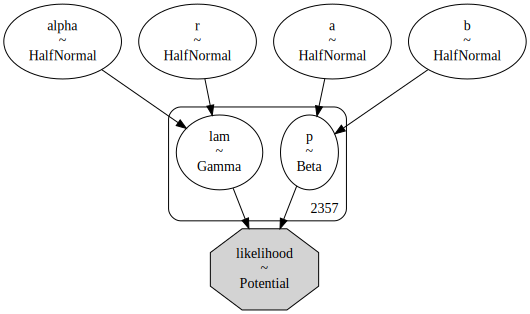

In [6]:
with pm.Model() as model_full:

    # hyper priors for the Gamma params    
    a = pm.HalfNormal(name="a", sigma=10)
    b = pm.HalfNormal(name="b", sigma=10)

    # hyper priors for the Beta params
    alpha = pm.HalfNormal(name="alpha", sigma=10)
    r = pm.HalfNormal(name="r", sigma=10)

    lam = pm.Gamma(name="lam", alpha=r, beta=alpha, shape=n)
    p = pm.Beta(name="p", alpha=a, beta=b, shape=n)

    def logp(x, t_x, T, x_zero):
        log_term_a = x * at.log(1 - p) + x * at.log(lam) - t_x * lam
        term_b_1 = -lam * (T - t_x)
        term_b_2 = at.log(p) - at.log(1 - p)
        log_term_b = pm.math.switch(x_zero, pm.math.logaddexp(term_b_1, term_b_2), term_b_1)

        return at.sum(log_term_a) + at.sum(log_term_b)

    likelihood = pm.Potential(
        name="likelihood",
        var=logp(x=x, t_x=t_x, T=T, x_zero=x_zero),
    )

pm.model_to_graphviz(model=model_full)

In [7]:
with model_full:
    trace_full = pm.sampling_jax.sample_numpyro_nuts(
        tune=3000,
        draws=6000,
        chains=4,
        target_accept=0.95,
    )

Compiling...
Compilation time =  0:00:04.155173
Sampling...


  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

Sampling time =  0:07:45.007734
Transforming variables...
Transformation time =  0:00:02.525344


This model takes a while to run and the results coincide with the ones from obtained using `lifetimes`.

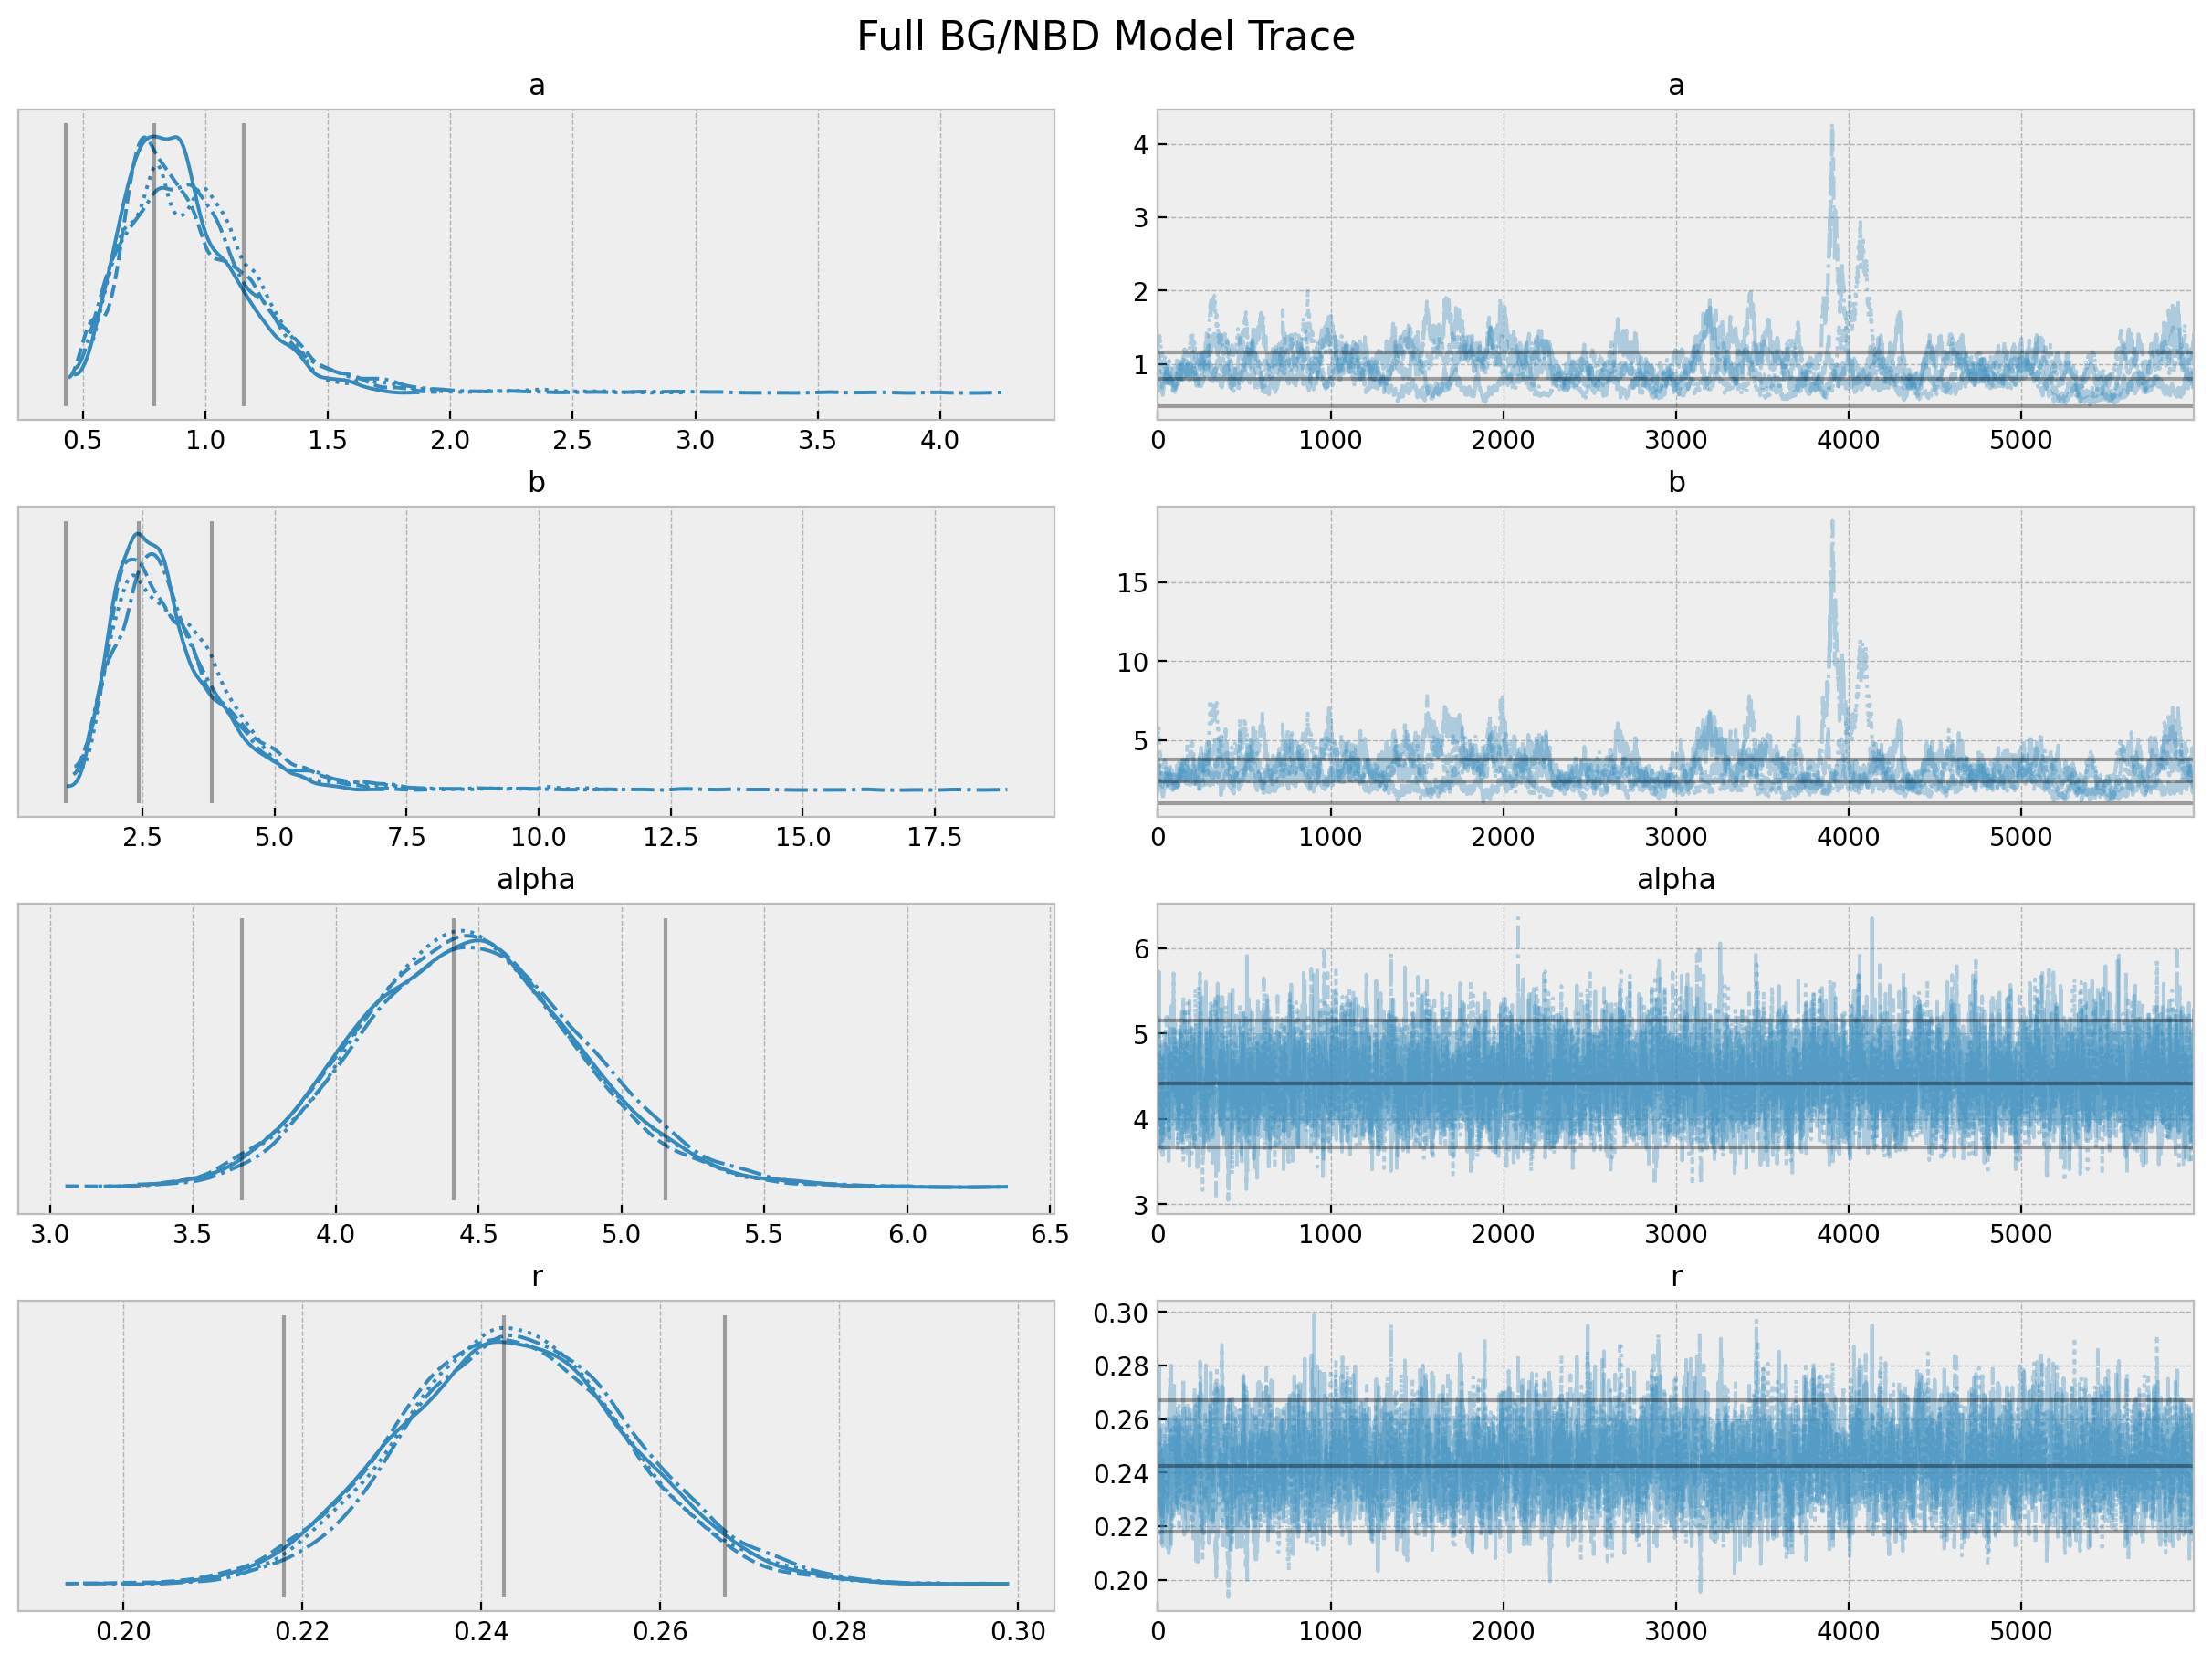

In [8]:
axes = az.plot_trace(
    data=trace_full,
    var_names=["a", "b", "alpha", "r"],
    lines=[
        (k, {}, [v.to_numpy()])
        for k, v in bgf.summary[
            ["coef", "lower 95% bound", "upper 95% bound"]
        ].T.items()
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
fig = axes[0][0].get_figure()
fig.suptitle("Full BG/NBD Model Trace", fontsize=16)


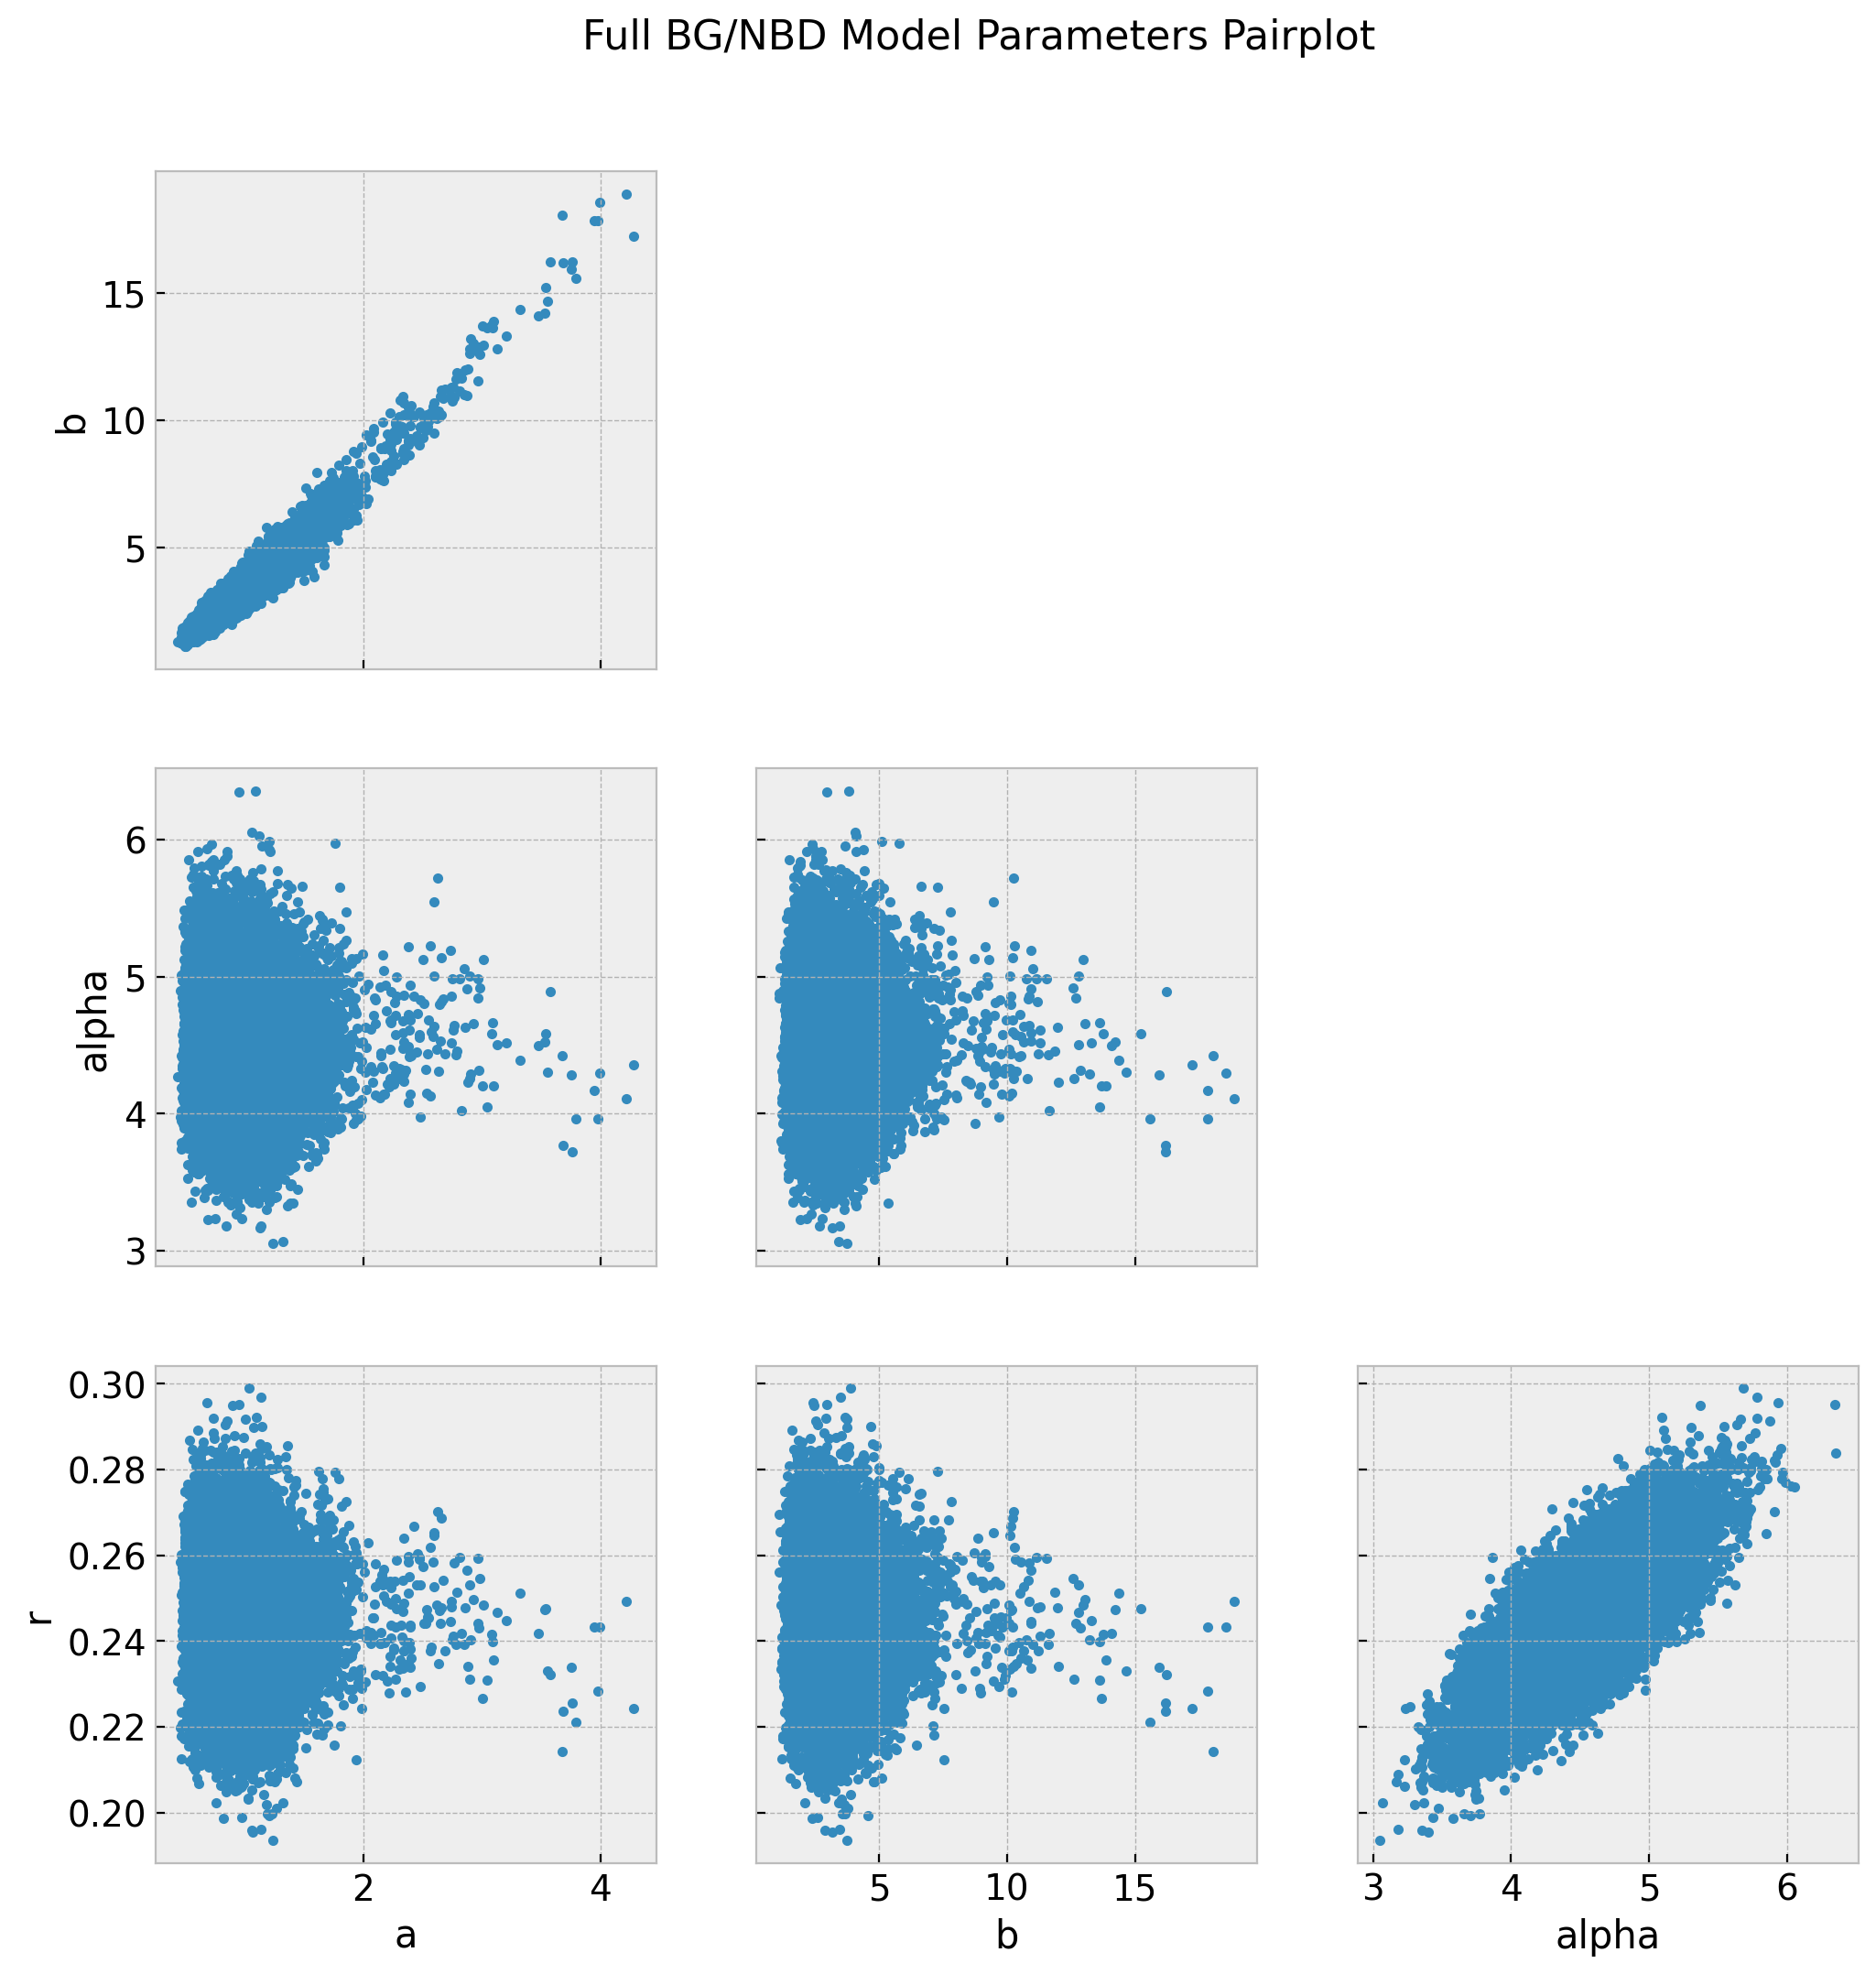

In [9]:
axes = az.plot_pair(data=trace_full, var_names=["a", "b", "alpha", "r"], figsize=(12, 12))
fig = axes[0][0].get_figure()
fig.suptitle("Full BG/NBD Model Parameters Pairplot", y=0.95, fontsize=16);

The chains for `a` and `b` do not look so good. We actually see from the pairplot that these parameters highly correlated. See the `r_hat` values below.

In [10]:
az.summary(data=trace_full, var_names=["a", "b", "alpha", "r"])

mean 
 sd 
 hdi_3% 
 hdi_97% 
 mcse_mean 
 mcse_sd 
 ess_bulk 
 ess_tail 
 r_hat 
 
 
 
 
 a 
 0.949 
 0.284 
 0.513 
 1.399 
 0.026 
 0.018 
 108.0 
 214.0 
 1.03 
 
 
 b 
 3.095 
 1.202 
 1.437 
 5.053 
 0.103 
 0.073 
 118.0 
 287.0 
 1.02 
 
 
 alpha 
 4.467 
 0.384 
 3.757 
 5.196 
 0.008 
 0.005 
 2608.0 
 6504.0 
 1.00 
 
 
 r 
 0.244 
 0.013 
 0.219 
 0.267 
 0.000 
 0.000 
 1913.0 
 4427.0 
 1.00

## Bayesian Model: Randomly Chosen Individual

One  drawback (computationally) of the `model_full` is that we have $\lambda$ and $p$ parameters per user. This does not scale that easily. That is why in practice one usually takes the expectation over $\lambda$ and $p$ to study a randomly chosen individual. One can compute this expectation analytically, see Section $5$ in ["Counting Your Customers" the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf) for the mathematical details. What is important to remark is this the end expression for the log-likelihood is relatively easy to write. Actually, the authors of the paper have a document which describes how to estimate the corresponding parameters in Excel, see [Implementing the BG/NBD Model for Customer Base Analysis in Excel](http://brucehardie.com/notes/004/bgnbd_spreadsheet_note.pdf). The resulting expression for the likelihood function is:

$$
L(a, b, \alpha, r|X=x, t_x, T) = A_{1}A_{2}(A_{3} + \delta_{x>0}A_4)
$$

where

\begin{align*}
A_{1} & = \frac{\Gamma(r + x)\alpha^{{r}}}{\Gamma(x)} \\
A_{2} & = \frac{\Gamma(a + b)\Gamma(b + x)}{\Gamma(b)\Gamma(a + b + x)} \\
A_{3} & = \left(\frac{1}{\alpha + T}\right)^{r+x} \\
A_{4} & = \left(\frac{a}{b + x - 1}\right)\left(\frac{1}{\alpha + t_x}\right)^{r + x}
\end{align*}

Computing the $\log (L(a, b, \alpha, r|X=x, t_x, T))$ is straight forward from these explicit expressions $a_{i}\coloneqq \log(A_{i})$. Note however that one has to be careful with the $a_{4}\coloneqq \log(A_4)$ term since we need to ensure that $b + x - 1 >0$ (otherwise should be zero). Fortunately, we wan simple re-factor the log-likelihood method code of th `lifetimes`'s `BetaGeoFitter` class from `numpy` to `theano` (see [`lifetimes.BetaGeoFitter._negative_log_likelihood`](https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/fitters/beta_geo_fitter.py#L164)). 

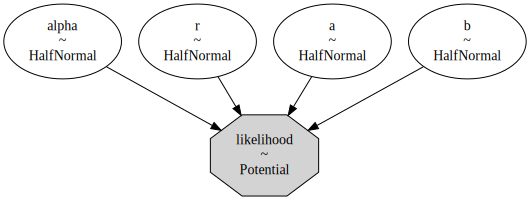

In [11]:
with pm.Model() as model:
   
    a = pm.HalfNormal(name="a", sigma=10)
    b = pm.HalfNormal(name="b", sigma=10)

    alpha = pm.HalfNormal(name="alpha", sigma=10)
    r = pm.HalfNormal(name="r", sigma=10)

    def logp(x, t_x, T, x_zero):
        a1 = at.gammaln(r + x) - at.gammaln(r) + r * at.log(alpha)
        a2 = at.gammaln(a + b) + at.gammaln(b + x) - at.gammaln(b) - at.gammaln(a + b + x)
        a3 = -(r + x) * at.log(alpha + T)
        a4 =  at.log(a) - at.log(b + at.maximum(x, 1) - 1) - (r + x) * at.log(t_x + alpha)
        max_a3_a4 = at.maximum(a3, a4)
        ll_1 = a1 + a2 
        ll_2 = at.log(at.exp(a3 - max_a3_a4) + at.exp(a4 - max_a3_a4) * pm.math.switch(x_zero, 1, 0)) + max_a3_a4
        return at.sum(ll_1 + ll_2)

    likelihood = pm.Potential(
        name="likelihood",
        var=logp(x=x, t_x=t_x, T=T, x_zero=x_zero),
    )

pm.model_to_graphviz(model=model)

Let us compute the posterior distributions:

In [12]:
with model:
    trace = pm.sampling_jax.sample_numpyro_nuts(
        tune=3000,
        draws=6000,
        chains=4,
        target_accept=0.95,
    )

Compiling...
Compilation time =  0:00:01.609945
Sampling...


  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

Sampling time =  0:01:48.408824
Transforming variables...
Transformation time =  0:00:00.010333


This model is much faster to train! We can now take a look at the traces, pairplots and summary statistics.

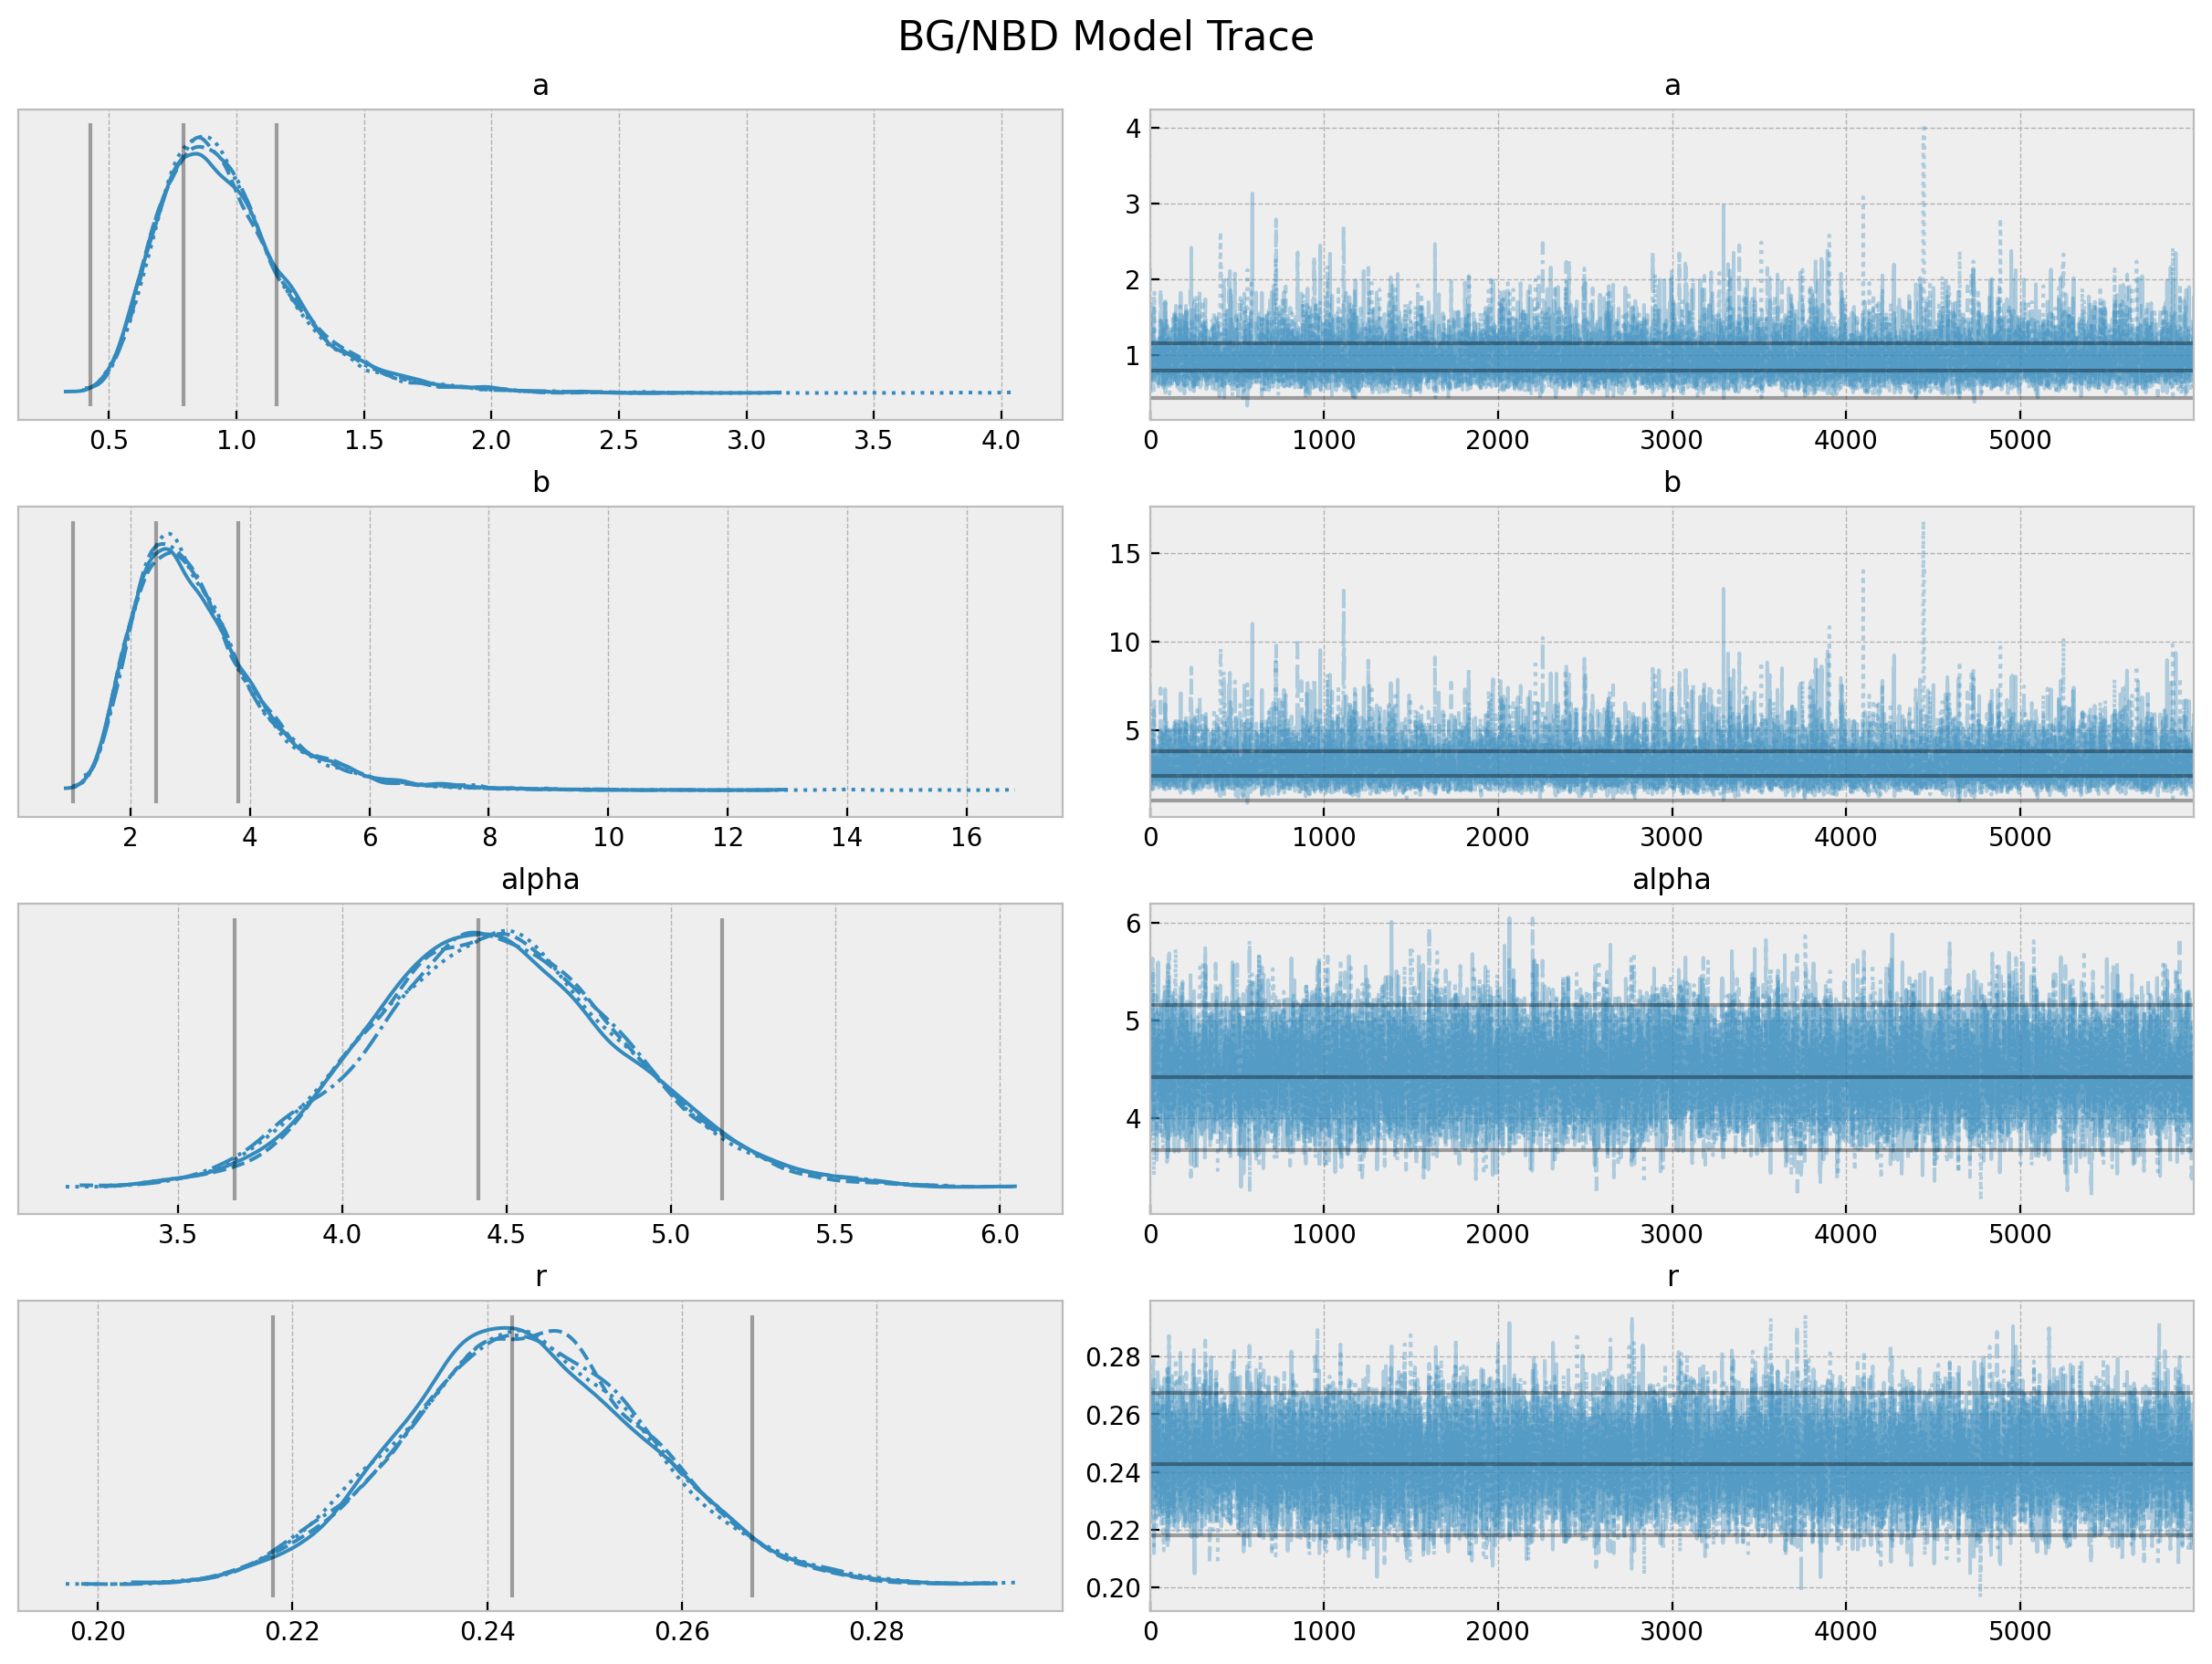

In [13]:
axes = az.plot_trace(
    data=trace,
    lines=[
        (k, {}, [v.to_numpy()])
        for k, v in bgf.summary[
            ["coef", "lower 95% bound", "upper 95% bound"]
        ].T.items()
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
fig = axes[0][0].get_figure()
fig.suptitle("BG/NBD Model Trace", fontsize=16)


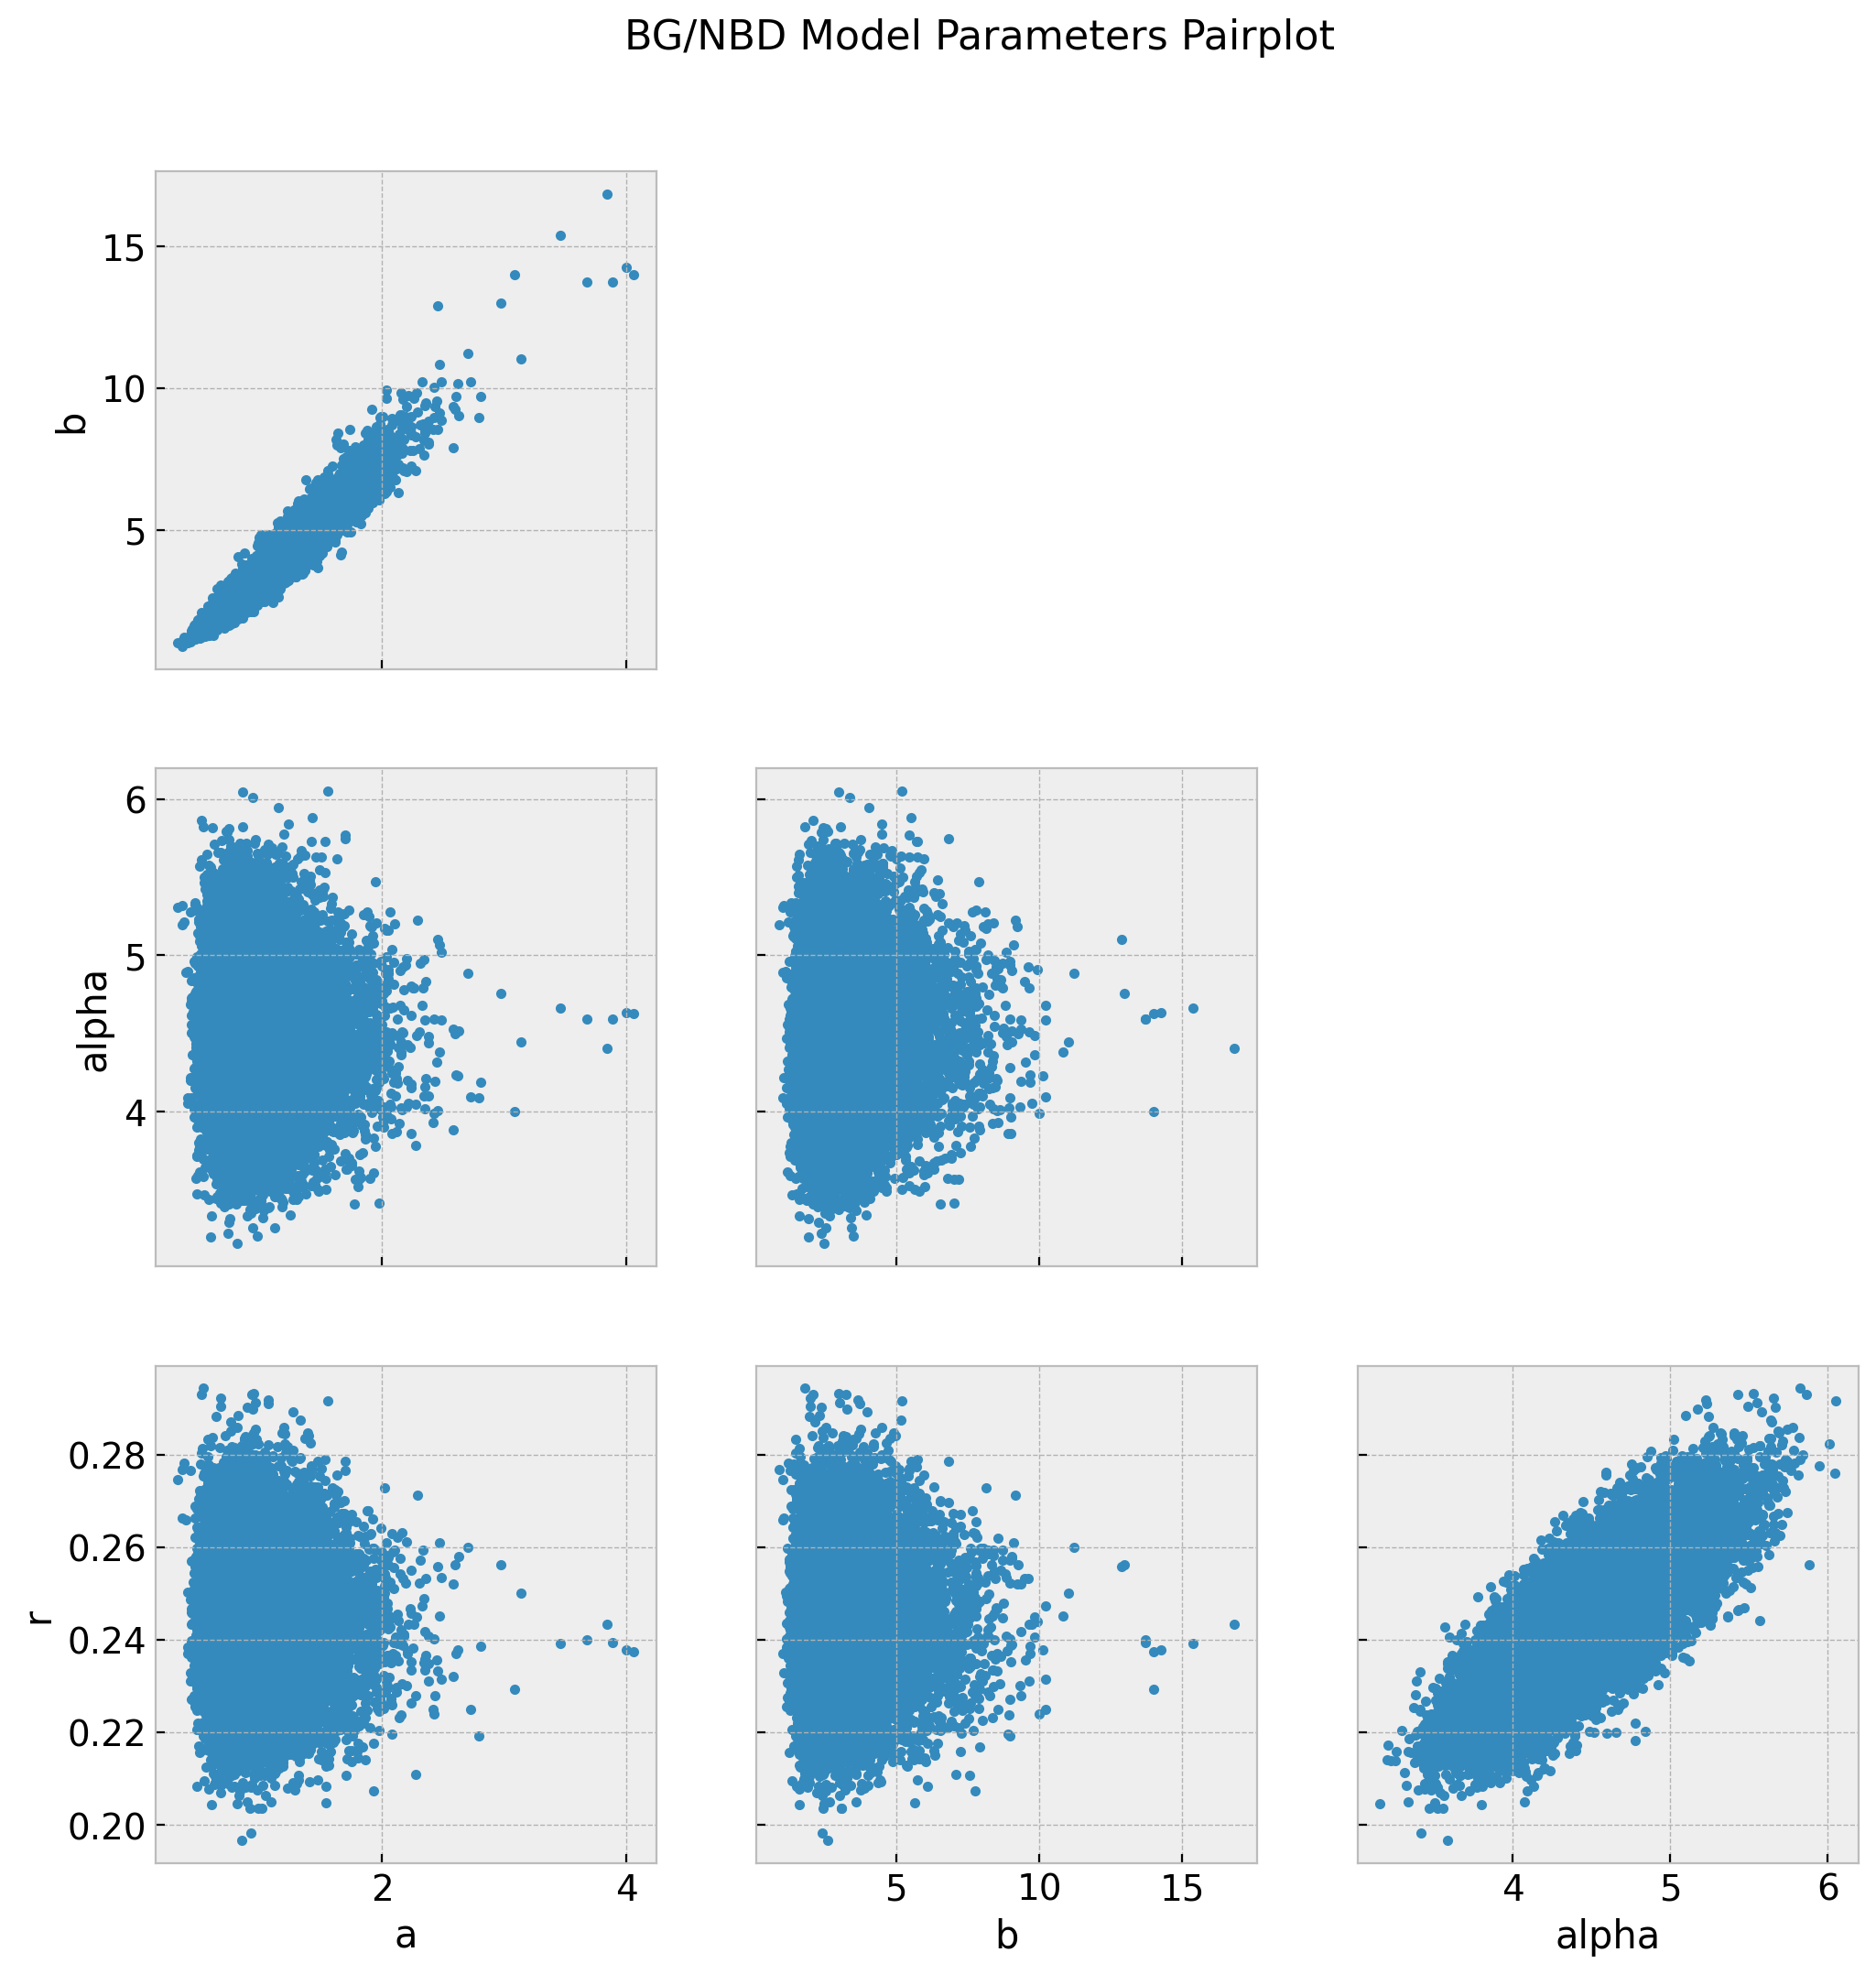

In [14]:
axes = az.plot_pair(data=trace, figsize=(12, 12))
fig = axes[0][0].get_figure()
fig.suptitle("BG/NBD Model Parameters Pairplot", y=0.95, fontsize=16);

In [15]:
az.summary(data=trace)

mean 
 sd 
 hdi_3% 
 hdi_97% 
 mcse_mean 
 mcse_sd 
 ess_bulk 
 ess_tail 
 r_hat 
 
 
 
 
 a 
 0.969 
 0.279 
 0.541 
 1.490 
 0.003 
 0.002 
 9063.0 
 9408.0 
 1.0 
 
 
 b 
 3.170 
 1.150 
 1.423 
 5.242 
 0.013 
 0.010 
 9134.0 
 9060.0 
 1.0 
 
 
 alpha 
 4.472 
 0.382 
 3.757 
 5.184 
 0.004 
 0.003 
 9292.0 
 10149.0 
 1.0 
 
 
 r 
 0.244 
 0.012 
 0.220 
 0.267 
 0.000 
 0.000 
 9521.0 
 11044.0 
 1.0

The summary statistics look overall good. In particular the chains values for `a` and `b` look better than the `model_full`.

### Probability of being alive

Now that we have posterior samples for the model parameters we can easily compute quantities of interest. For example, let us compute the *conditional probability of being alive*, see the note [Computing P(alive) Using
the BG/NBD Model](https://brucehardie.com/notes/021/palive_for_BGNBD.pdf). Again, we can simply port the corresponding method from [`lifetimes.BetaGeoFitter.conditional_probability_alive`](https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html#lifetimes.fitters.beta_geo_fitter.BetaGeoFitter.conditional_probability_alive).

In [16]:
# See https://docs.pymc.io/en/stable/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement."""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]


def conditional_probability_alive(trace, x, t_x, T):
    n_vals = x.shape[0]

    a = _sample(array=trace.posterior["a"].to_numpy(), n_samples=n_vals)
    b = _sample(array=trace.posterior["b"].to_numpy(), n_samples=n_vals)
    alpha = _sample(array=trace.posterior["alpha"].to_numpy(), n_samples=n_vals)
    r = _sample(array=trace.posterior["r"].to_numpy(), n_samples=n_vals)

    log_div = (
        (r + x[..., None]) * np.log((alpha + T[..., None]) / (alpha + t_x[..., None]))
        + np.log(a / (b + np.maximum(x[..., None], 1) - 1))
    )
    return np.where(x[..., None] == 0, 1.0, expit(-log_div))


p_alive_sample = conditional_probability_alive(trace, x, t_x, T)

We compute these probabilities directly from the `BetaGeoFitter` object directly so that we could compare the results.

In [17]:
p_alive = bgf.conditional_probability_alive(x, t_x, T)

We can simply plot some example predictions:

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_98572/153960483.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=p_alive_sample[idx], color="C0", fill=True, ax=ax)
/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_98572/153960483.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=p_alive_sample[idx], color="C0", fill=True, ax=ax)
/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_98572/153960483.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=p_alive_sample[idx], color="C0", fill=True, ax=ax)
/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_98572/153960483.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdepl

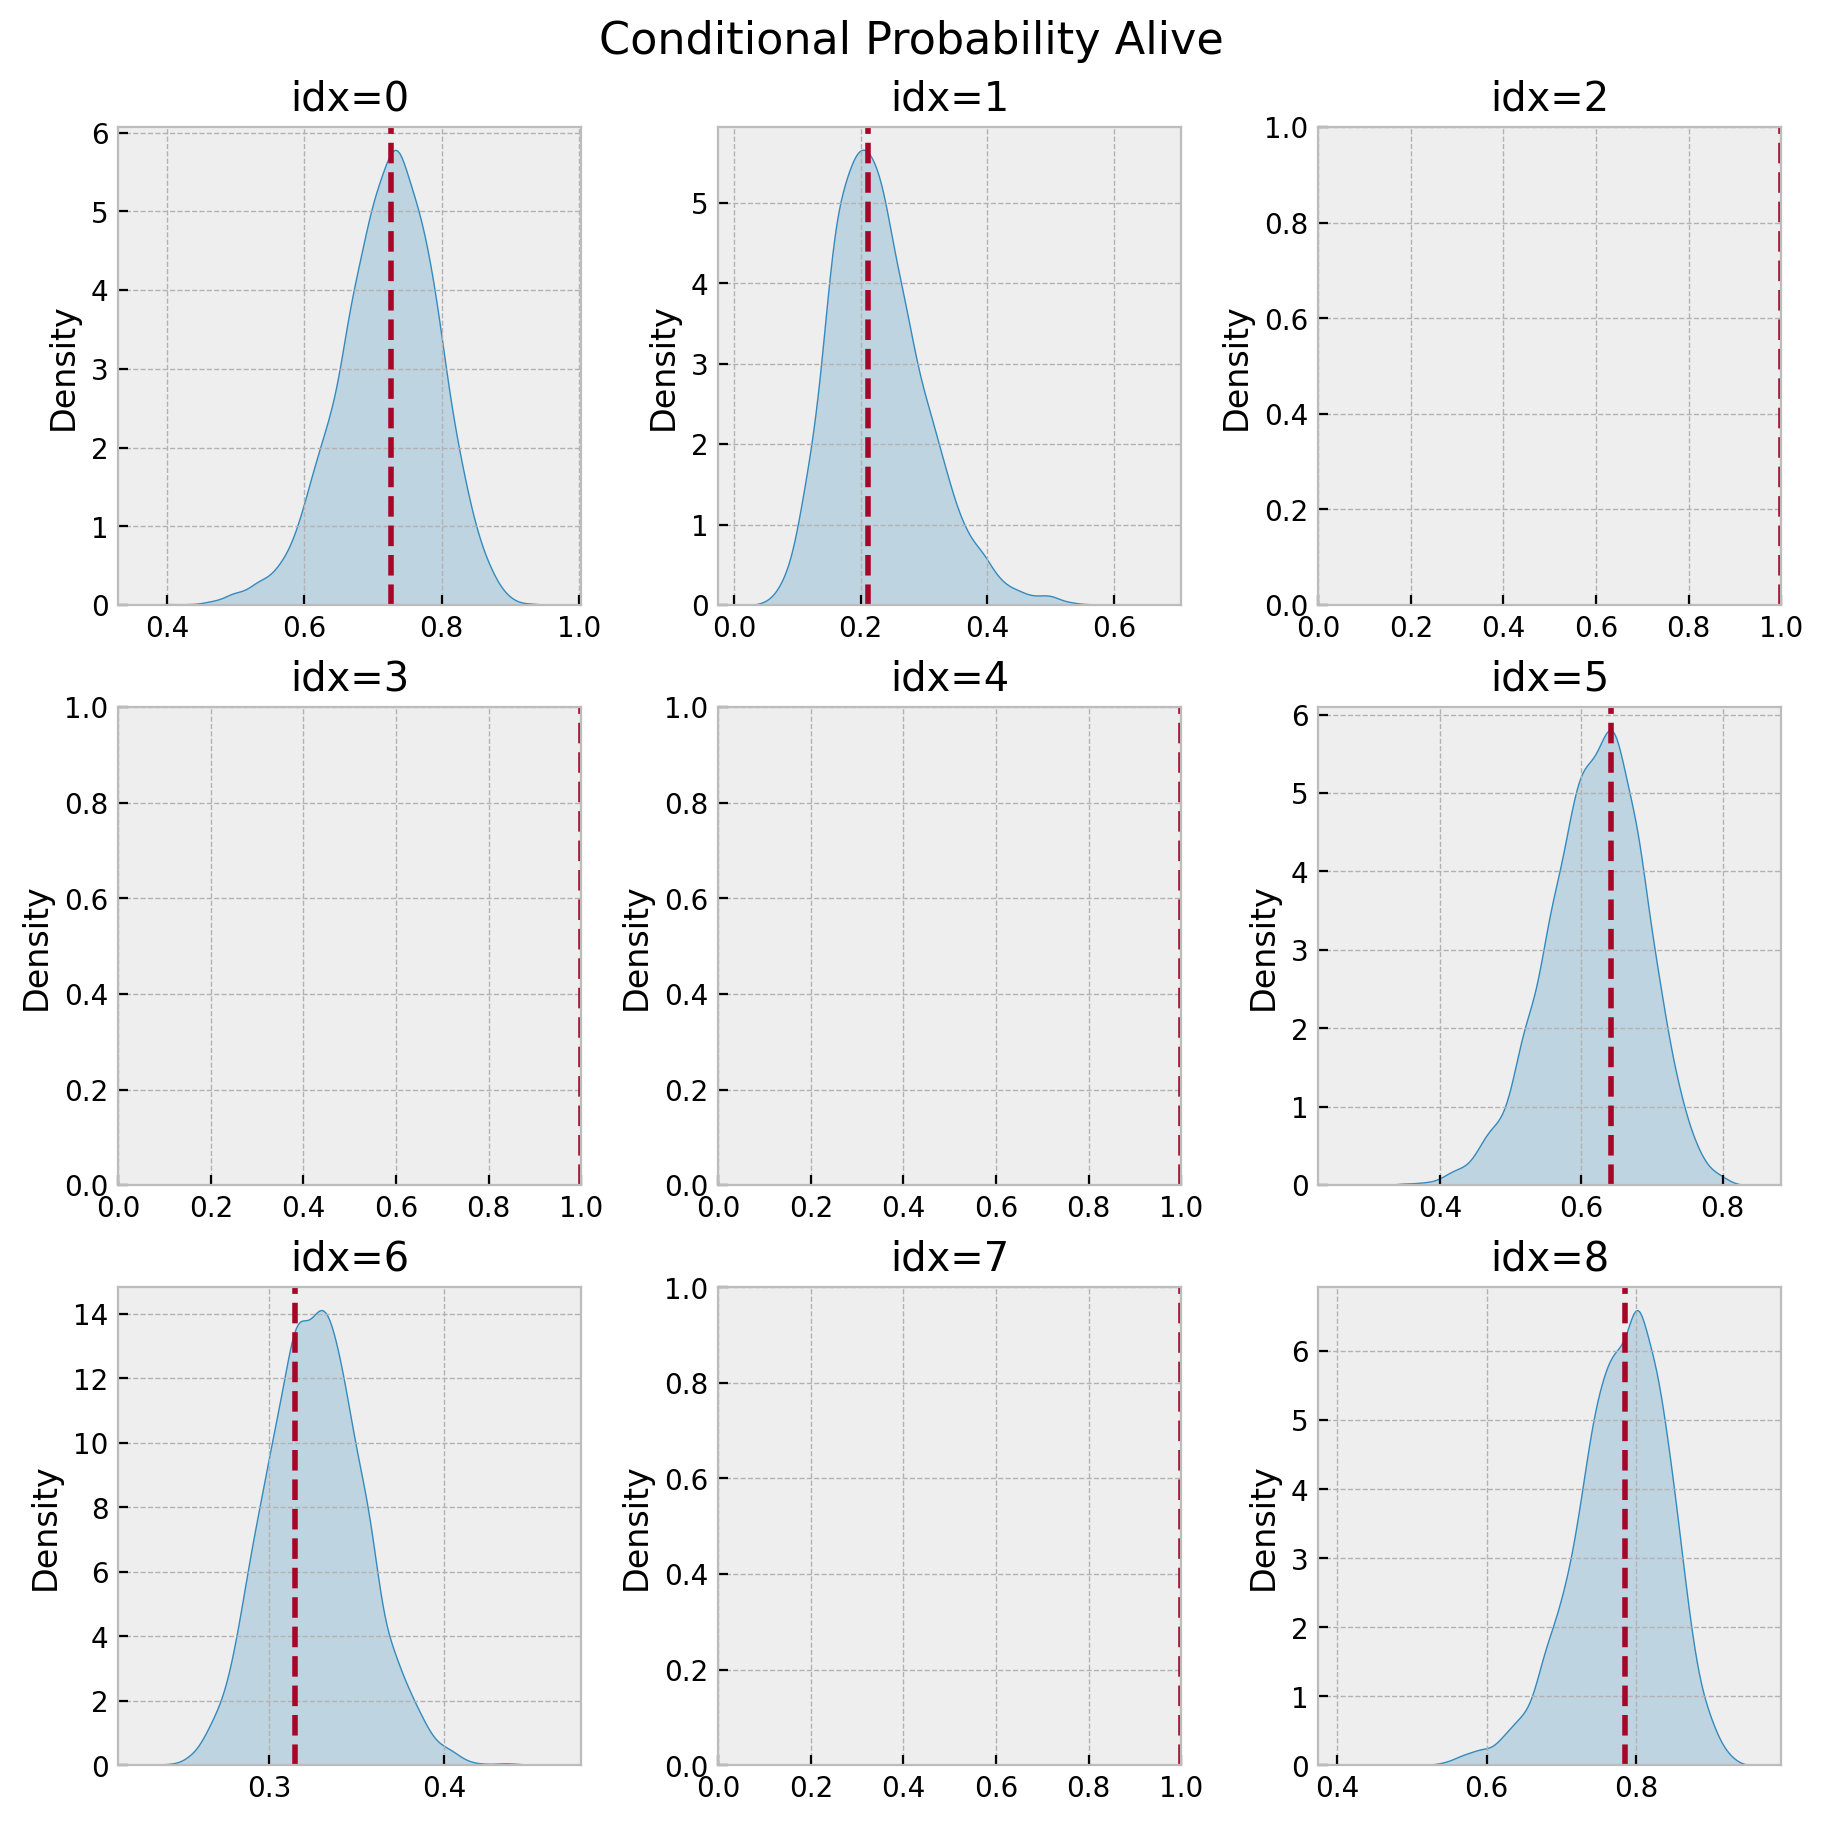

In [18]:
def plot_conditional_probability_alive(p_alive_sample, p_alive, idx, ax):
    sns.kdeplot(x=p_alive_sample[idx], color="C0", fill=True, ax=ax)
    ax.axvline(x=p_alive[idx], color="C1", linestyle="--")
    ax.set(title=f"idx={idx}")
    return ax

fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(9, 9),
    layout="constrained"
)
for idx, ax in enumerate(axes.flatten()):
    plot_conditional_probability_alive(p_alive_sample, p_alive, idx, ax)

fig.suptitle("Conditional Probability Alive", fontsize=16);

The plots without density correspond to users with probability of being active of $1.0$. Note for example that for `idx=2` we have:

In [19]:
idx = 2
# probability estimation lifetimes model
p_alive[idx]

1.0

In [20]:
# posterior samples
np.unique(p_alive_sample[idx])

array([1.])

Hence, the bayesian model also captures the case when the user is certainly alive (because did a very recent purchase).

### Predicting the number of future transactions

We can do something similar for the expected number of future transactions using the analytical expression implemented in the method [`lifetimes.BetaGeoFitter. conditional_expected_number_of_purchases_up_to_time`](https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html#lifetimes.fitters.beta_geo_fitter.BetaGeoFitter.conditional_expected_number_of_purchases_up_to_time).

In [21]:
def conditional_expected_number_of_purchases_up_to_time(t, trace, x, t_x, T):
    n_vals = x.shape[0]
    a = _sample(array=trace.posterior["a"].to_numpy(), n_samples=n_vals)
    b = _sample(array=trace.posterior["b"].to_numpy(), n_samples=n_vals)
    alpha = _sample(array=trace.posterior["alpha"].to_numpy(), n_samples=n_vals)
    r = _sample(array=trace.posterior["r"].to_numpy(), n_samples=n_vals)

    _a = r + x[..., None]
    _b = b + x[..., None]
    _c = a + b + x[..., None] - 1
    _z = t / (alpha + T[..., None] + t)
    ln_hyp_term = np.log(hyp2f1(_a, _b, _c, _z))

    ln_hyp_term_alt = np.log(hyp2f1(_c - _a, _c - _b, _c, _z)) + (
        _c - _a - _b
    ) * np.log(1 - _z)
    ln_hyp_term = np.where(np.isinf(ln_hyp_term), ln_hyp_term_alt, ln_hyp_term)
    first_term = (a + b + x[..., None] - 1) / (a - 1)
    second_term = 1 - np.exp(
        ln_hyp_term
        + (r + x[..., None])
        * np.log((alpha + T[..., None]) / (alpha + t + T[..., None]))
    )

    numerator = first_term * second_term
    denominator = 1 + (x > 0)[..., None] * (a / (b + x[..., None] - 1)) * (
        (alpha + T[..., None]) / (alpha + t_x[..., None])
    ) ** (r + x[..., None])

    return numerator / denominator


# generate posterior samples
t = 90
conditional_expected_number_of_purchases_up_to_time_samples = (
    conditional_expected_number_of_purchases_up_to_time(t, trace, x, t_x, T)
)

We can now compare it with the predictions from the maximum likelihood model.

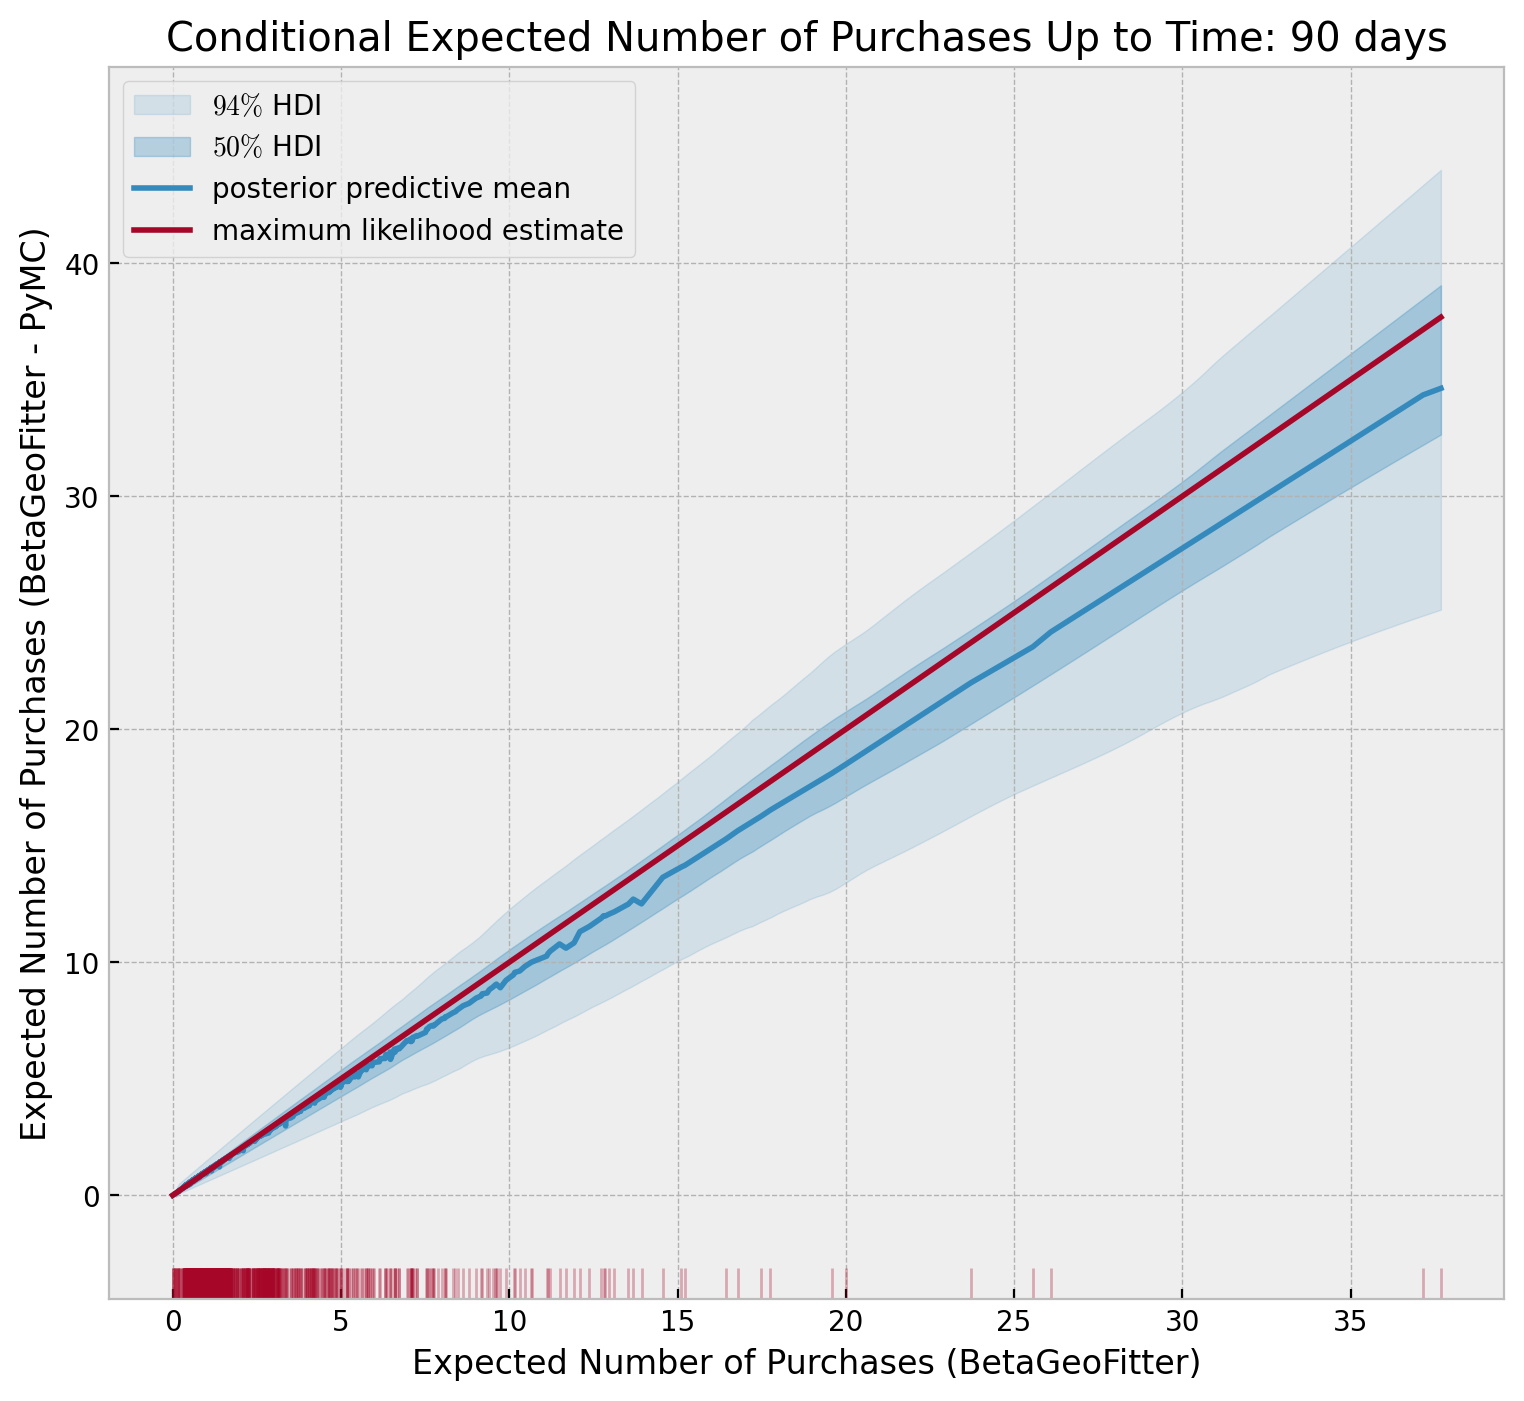

In [22]:
conditional_expected_number_of_purchases_up_to_time = (
    bgf.conditional_expected_number_of_purchases_up_to_time(t, x, t_x, T)
)

idx_sort = np.argsort(conditional_expected_number_of_purchases_up_to_time)

fig, ax = plt.subplots(figsize=(9, 8))


az.plot_hdi(
    x=conditional_expected_number_of_purchases_up_to_time[idx_sort],
    y=conditional_expected_number_of_purchases_up_to_time_samples[idx_sort, :].T,
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.15, "label": r"$94\%$ HDI"},
    ax=ax,
)

az.plot_hdi(
    x=conditional_expected_number_of_purchases_up_to_time[idx_sort],
    y=conditional_expected_number_of_purchases_up_to_time_samples[idx_sort, :].T,
    hdi_prob=0.5,
    color="C0",
    fill_kwargs={"alpha": 0.3, "label": r"$50\%$ HDI"},
    ax=ax,
)

sns.lineplot(
    x=conditional_expected_number_of_purchases_up_to_time,
    y=conditional_expected_number_of_purchases_up_to_time_samples.mean(axis=1),
    color="C0",
    label="posterior predictive mean",
    ax=ax,
)

sns.lineplot(
    x=conditional_expected_number_of_purchases_up_to_time,
    y=conditional_expected_number_of_purchases_up_to_time,
    color="C1",
    label="maximum likelihood estimate",
    ax=ax,
)

sns.rugplot(
    x=conditional_expected_number_of_purchases_up_to_time,
    color="C1",
    lw=1,
    alpha=0.3,
    ax=ax,
)

ax.legend(loc="upper left")
ax.set(
    title=f"Conditional Expected Number of Purchases Up to Time: {t} days",
    xlabel="Expected Number of Purchases (BetaGeoFitter)",
    ylabel="Expected Number of Purchases (BetaGeoFitter - PyMC)"
);

**Remark:** We can compare both model's parameters:

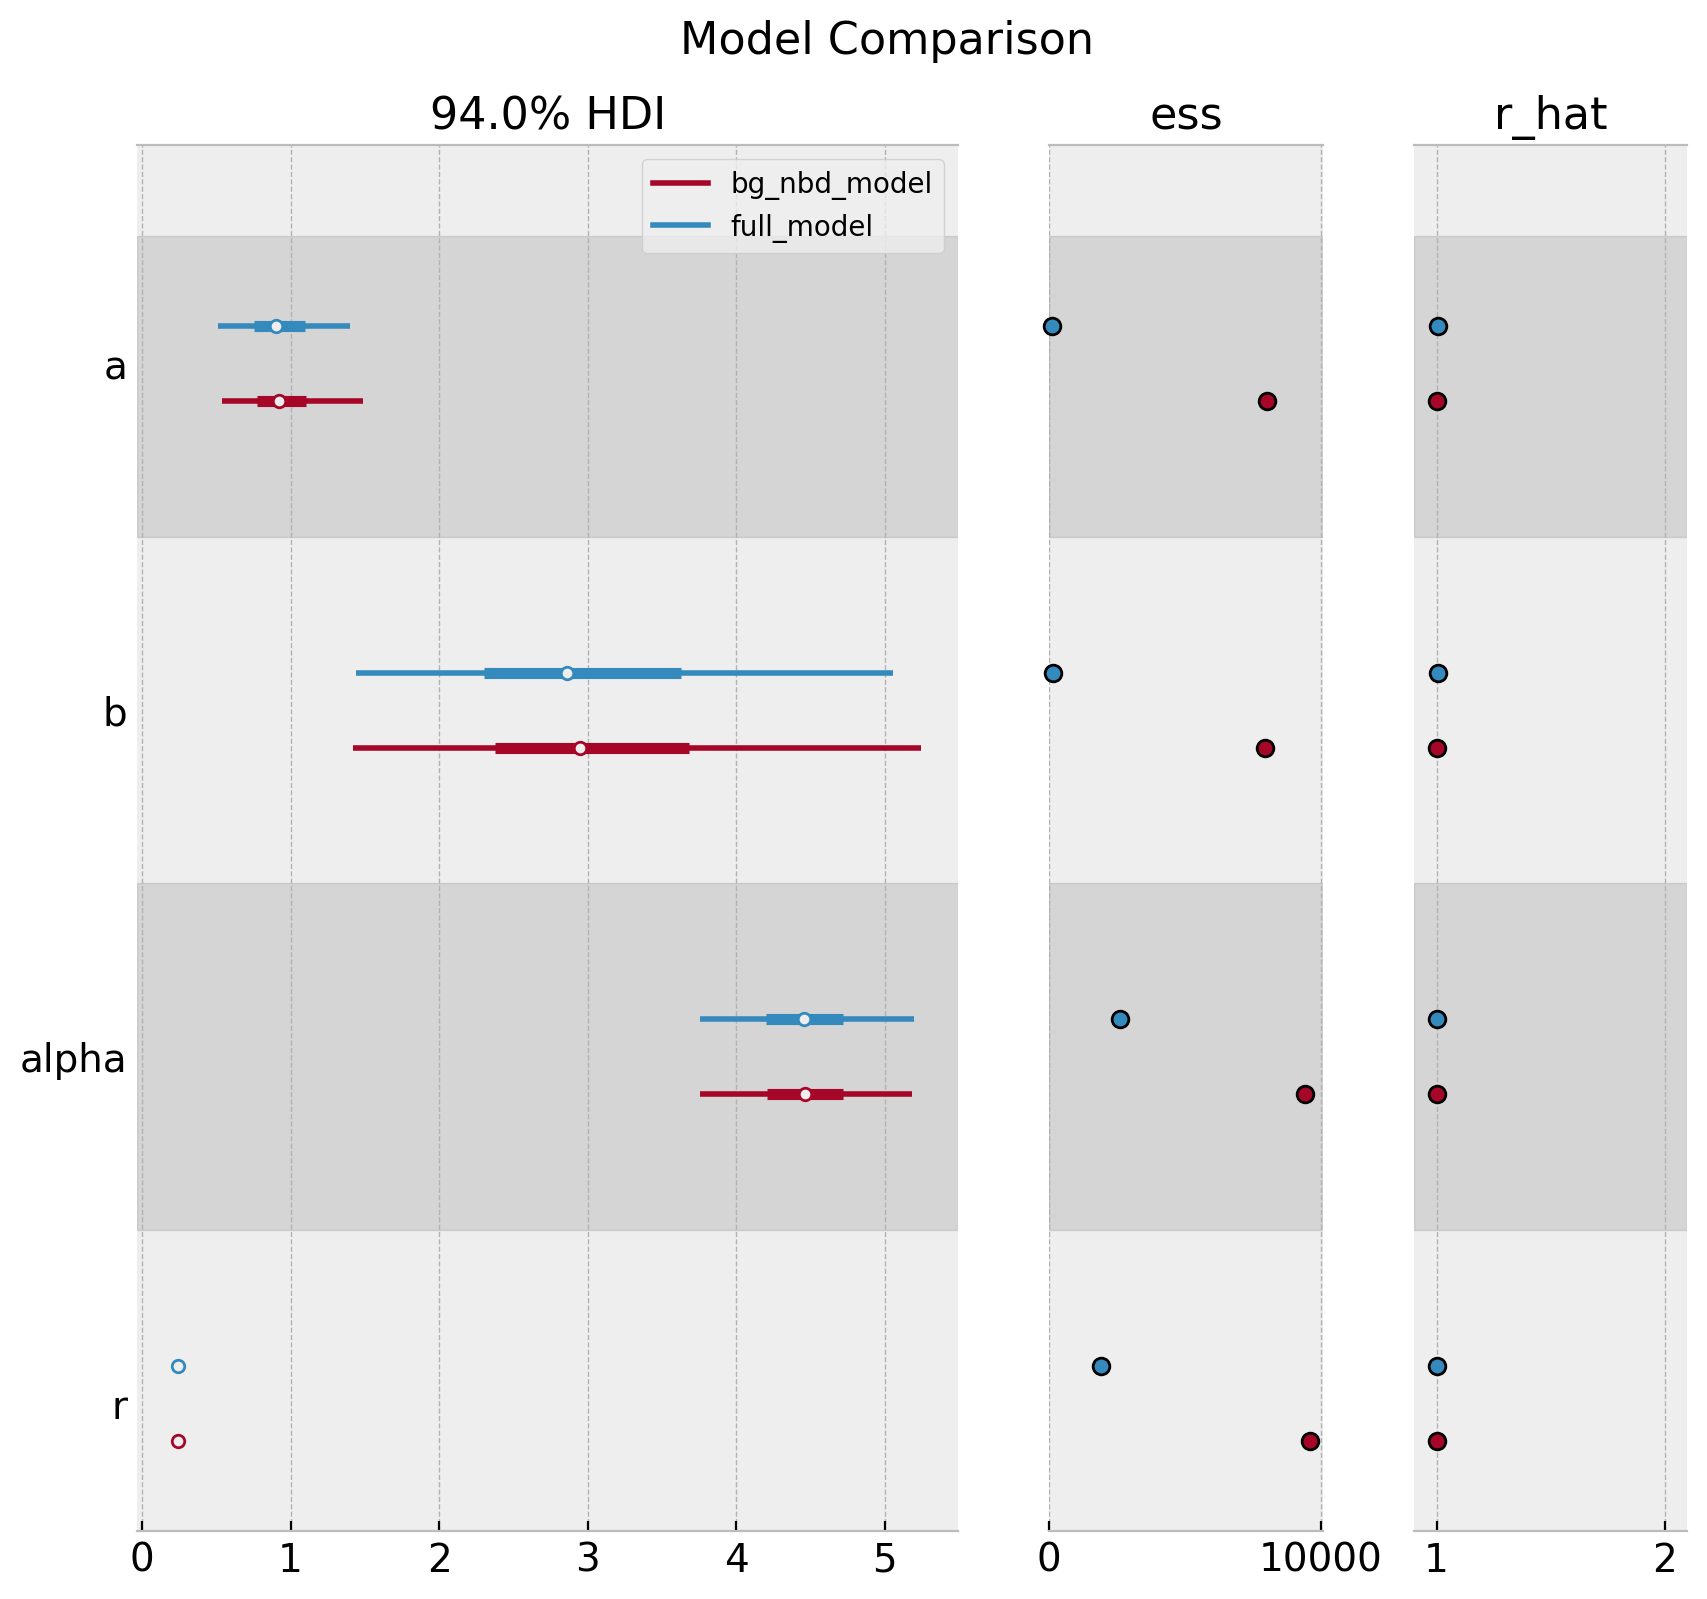

In [23]:
axes = az.plot_forest(
    data=[trace_full, trace],
    model_names=["full_model", "bg_nbd_model"],
    var_names=["a", "b", "alpha", "r"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(10, 9)
)
plt.gcf().suptitle("Model Comparison", y=0.95, fontsize=16);

We indeed see that the `full_model` has a lower [`ess`](https://arviz-devs.github.io/arviz/api/generated/arviz.ess.html).

## Bayesian Model: Randomly Chosen Individual with Time-Independent Covariates

In the research note [Incorporating Time-Invariant Covariates into the Pareto/NBD and BG/NBD Models](http://brucehardie.com/notes/019/time_invariant_covariates.pdf) by Peter S. Fader and Bruce G. S. Hardie, it is shown how easy (after some clever math manipulations of course!) to incorporate time-invariant covariates into the BG/NBD model. The main idea is to allow covariates $z_1$ and $z_2$ to explain the cross-sectional heterogeneity in the purchasing process and cross-sectional heterogeneity in the dropout process respectively (see model description above). The authors show that the likelihood and quantities of interests computed by computing expectations (e.g. quantities which have a close expression so that, for example can be computed in Excel), remain almost the same. One only has to replace:

\begin{align*}
\alpha & \longmapsto \alpha_{0}\exp(-\gamma_{1}^{T}z_{1}) \\
a & \longmapsto a_{0}\exp(\gamma_{2}^{T}z_{2}) \\
b & \longmapsto b_{0}\exp(\gamma_{3}^{T}z_{2})
\end{align*}

where $\gamma_{i}$ are the model coefficients.

Let us modify the frequency of our data set by reducing it as a function of a covariate $z$.

In [24]:
np.random.seed(42)

# construct covariate
mu = 0.4
rho = 0.7
z = np.random.binomial(n=1, p=mu, size=x.size)
# change frequency values by reducing it the values where z !=0
x_z = np.floor(x * (1 - (rho * z)))
# make sure the recency is zero whenever the frequency is zero
t_x_z = t_x.copy()
t_x_z[np.argwhere(x_z == 0).flatten()] = 0
# sanity checks
assert x_z.min() == 0
assert np.all(t_x_z[np.argwhere(x_z == 0).flatten()] == 0)
# convenient indicator function
int_vec = np.vectorize(int)
x_zero_z = int_vec(x_z > 0)

First, we fit the `lifetimes` model with this modified data.

In [25]:
bgf_cov = BetaGeoFitter()
bgf_cov.fit(frequency=x_z, recency=t_x_z, T=T)

bgf_cov.summary

coef 
 se(coef) 
 lower 95% bound 
 upper 95% bound 
 
 
 
 
 r 
 0.142129 
 0.008739 
 0.125000 
 0.159258 
 
 
 alpha 
 4.252136 
 0.447587 
 3.374866 
 5.129407 
 
 
 a 
 0.750734 
 0.283204 
 0.195654 
 1.305815 
 
 
 b 
 3.157024 
 1.505522 
 0.206201 
 6.107846

Next, we write the bayesian model, which adds term $\alpha \longmapsto \alpha_{0}\exp(-\gamma_{1}^{T}z_{1})$ to model the effect of $z$ on the  to explain the cross-sectional heterogeneity in the purchasing process (because we are modifying the frequency as a function of $z$).

**Remark:** I also tried adding the covariate $z_2 = z$, but the resulting model had trouble sampling. By looking into the pair-plots of the posterior distributions (which had many divergences) I found that the terms $a_0$ and $b_0$ where highly correlated (actually, $g_2$ ($=\gamma_{2}$)and $g_3$ ($=\gamma_{3}$) as well, see notation below). This indicates that we might need a different and more appropriate parametrization of the log-likelihood function.

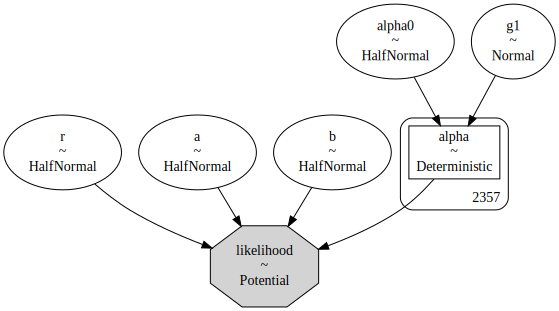

In [26]:
with pm.Model() as model_cov:

    # a0 = pm.HalfNormal(name="a0", sigma=10)
    # g2 = pm.Normal(name="g2", mu=0, sigma=10)
    # a = a0 * tt.exp(g2 * z)
    a = pm.HalfNormal(name="a", sigma=10)
    
    # b0 = pm.HalfNormal(name="b0", sigma=10)
    # g3 = pm.Normal(name="g3", mu=0, sigma=10)
    # b = tt.exp(g3 * z)
    b = pm.HalfNormal(name="b", sigma=10)

    alpha0 = pm.HalfNormal(name="alpha0", sigma=10)
    g1 = pm.Normal(name="g1", mu=0, sigma=10)
    alpha = pm.Deterministic(name="alpha", var=alpha0 * at.exp(- g1 * z))
    
    r = pm.HalfNormal(name="r", sigma=10)

    def logp(x, t_x, T, x_zero):
        a1 = at.gammaln(r + x) - at.gammaln(r) + r * at.log(alpha)
        a2 = at.gammaln(a + b) + at.gammaln(b + x) - at.gammaln(b) - at.gammaln(a + b + x)
        a3 = -(r + x) * at.log(alpha + T)
        a4 =  at.log(a) - at.log(b + at.maximum(x, 1) - 1) - (r + x) * at.log(t_x + alpha)
        max_a3_a4 = at.maximum(a3, a4)
        ll_1 = a1 + a2 
        ll_2 = at.log(at.exp(a3 - max_a3_a4) + at.exp(a4 - max_a3_a4) * pm.math.switch(x_zero, 1, 0)) + max_a3_a4
        return at.sum(ll_1 + ll_2)

    likelihood = pm.Potential(
        name="likelihood",
        var=logp(x=x_z, t_x=t_x_z, T=T, x_zero=x_zero_z),
    )

pm.model_to_graphviz(model=model_cov)

In [27]:
with model_cov:
    trace_cov = pm.sampling_jax.sample_numpyro_nuts(
        tune=3000,
        draws=6000,
        chains=4,
        target_accept=0.95,
    )

Compiling...
Compilation time =  0:00:01.736940
Sampling...


  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

Sampling time =  0:02:22.688871
Transforming variables...
Transformation time =  0:00:03.619413


In [28]:
az.summary(data=trace_cov, var_names=["~alpha"])

mean 
 sd 
 hdi_3% 
 hdi_97% 
 mcse_mean 
 mcse_sd 
 ess_bulk 
 ess_tail 
 r_hat 
 
 
 
 
 g1 
 -2.860 
 0.141 
 -3.133 
 -2.606 
 0.001 
 0.001 
 15215.0 
 14112.0 
 1.0 
 
 
 a 
 1.175 
 0.571 
 0.380 
 2.192 
 0.006 
 0.004 
 10343.0 
 10398.0 
 1.0 
 
 
 b 
 5.264 
 3.162 
 1.321 
 10.998 
 0.033 
 0.024 
 10325.0 
 10249.0 
 1.0 
 
 
 alpha0 
 4.024 
 0.434 
 3.232 
 4.854 
 0.004 
 0.003 
 11666.0 
 13128.0 
 1.0 
 
 
 r 
 0.226 
 0.015 
 0.198 
 0.253 
 0.000 
 0.000 
 12265.0 
 13506.0 
 1.0

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning: A valid var_name should be provided, found {'alpha'} expected from {'r', 'alpha0', 'g1', 'a', 'b'}
  warnings.warn(


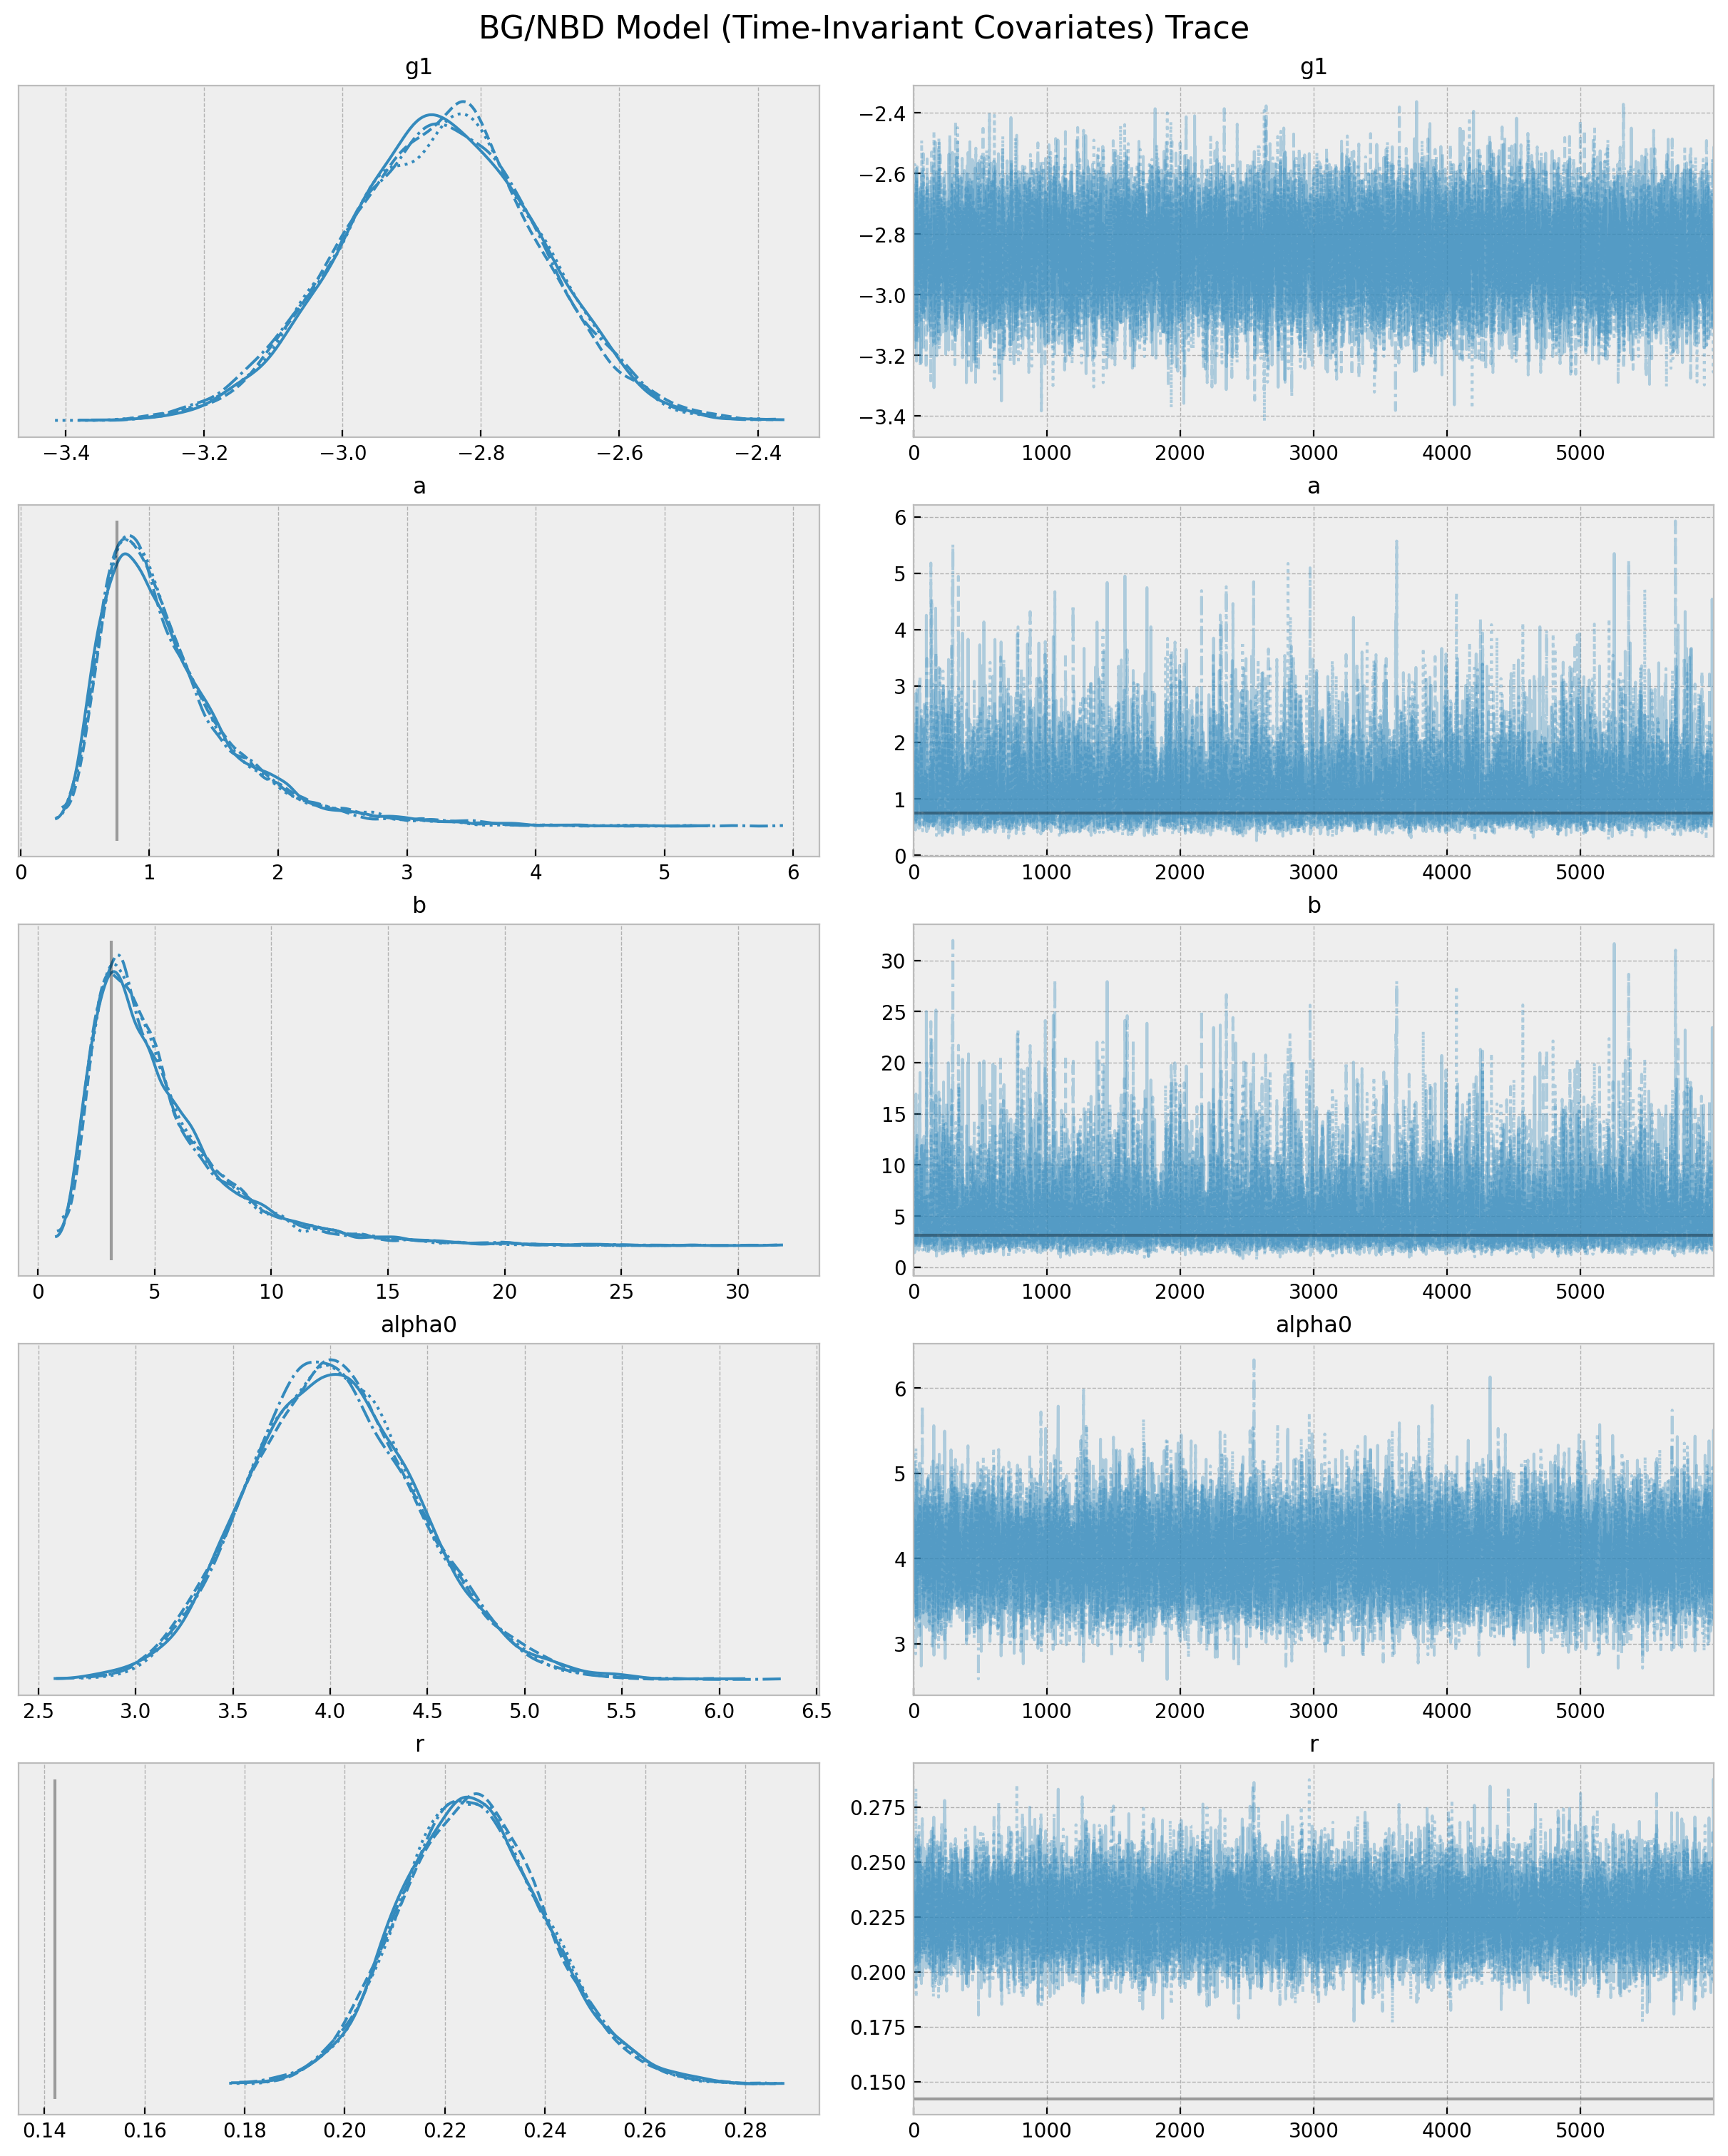

In [29]:
axes = az.plot_trace(
    data=trace_cov,
    var_names=["~alpha"],
    lines=[(k, {}, [v]) for k, v in bgf_cov.summary["coef"].items()],
    compact=True,
    backend_kwargs={
        "figsize": (12, 15),
        "layout": "constrained"
    }
)
fig = axes[0][0].get_figure()
fig.suptitle("BG/NBD Model (Time-Invariant Covariates) Trace", fontsize=16);

We indeed see a difference in the model parameters as compared with the model without covariates `bgf_cov` (note specially the shift in $r$).

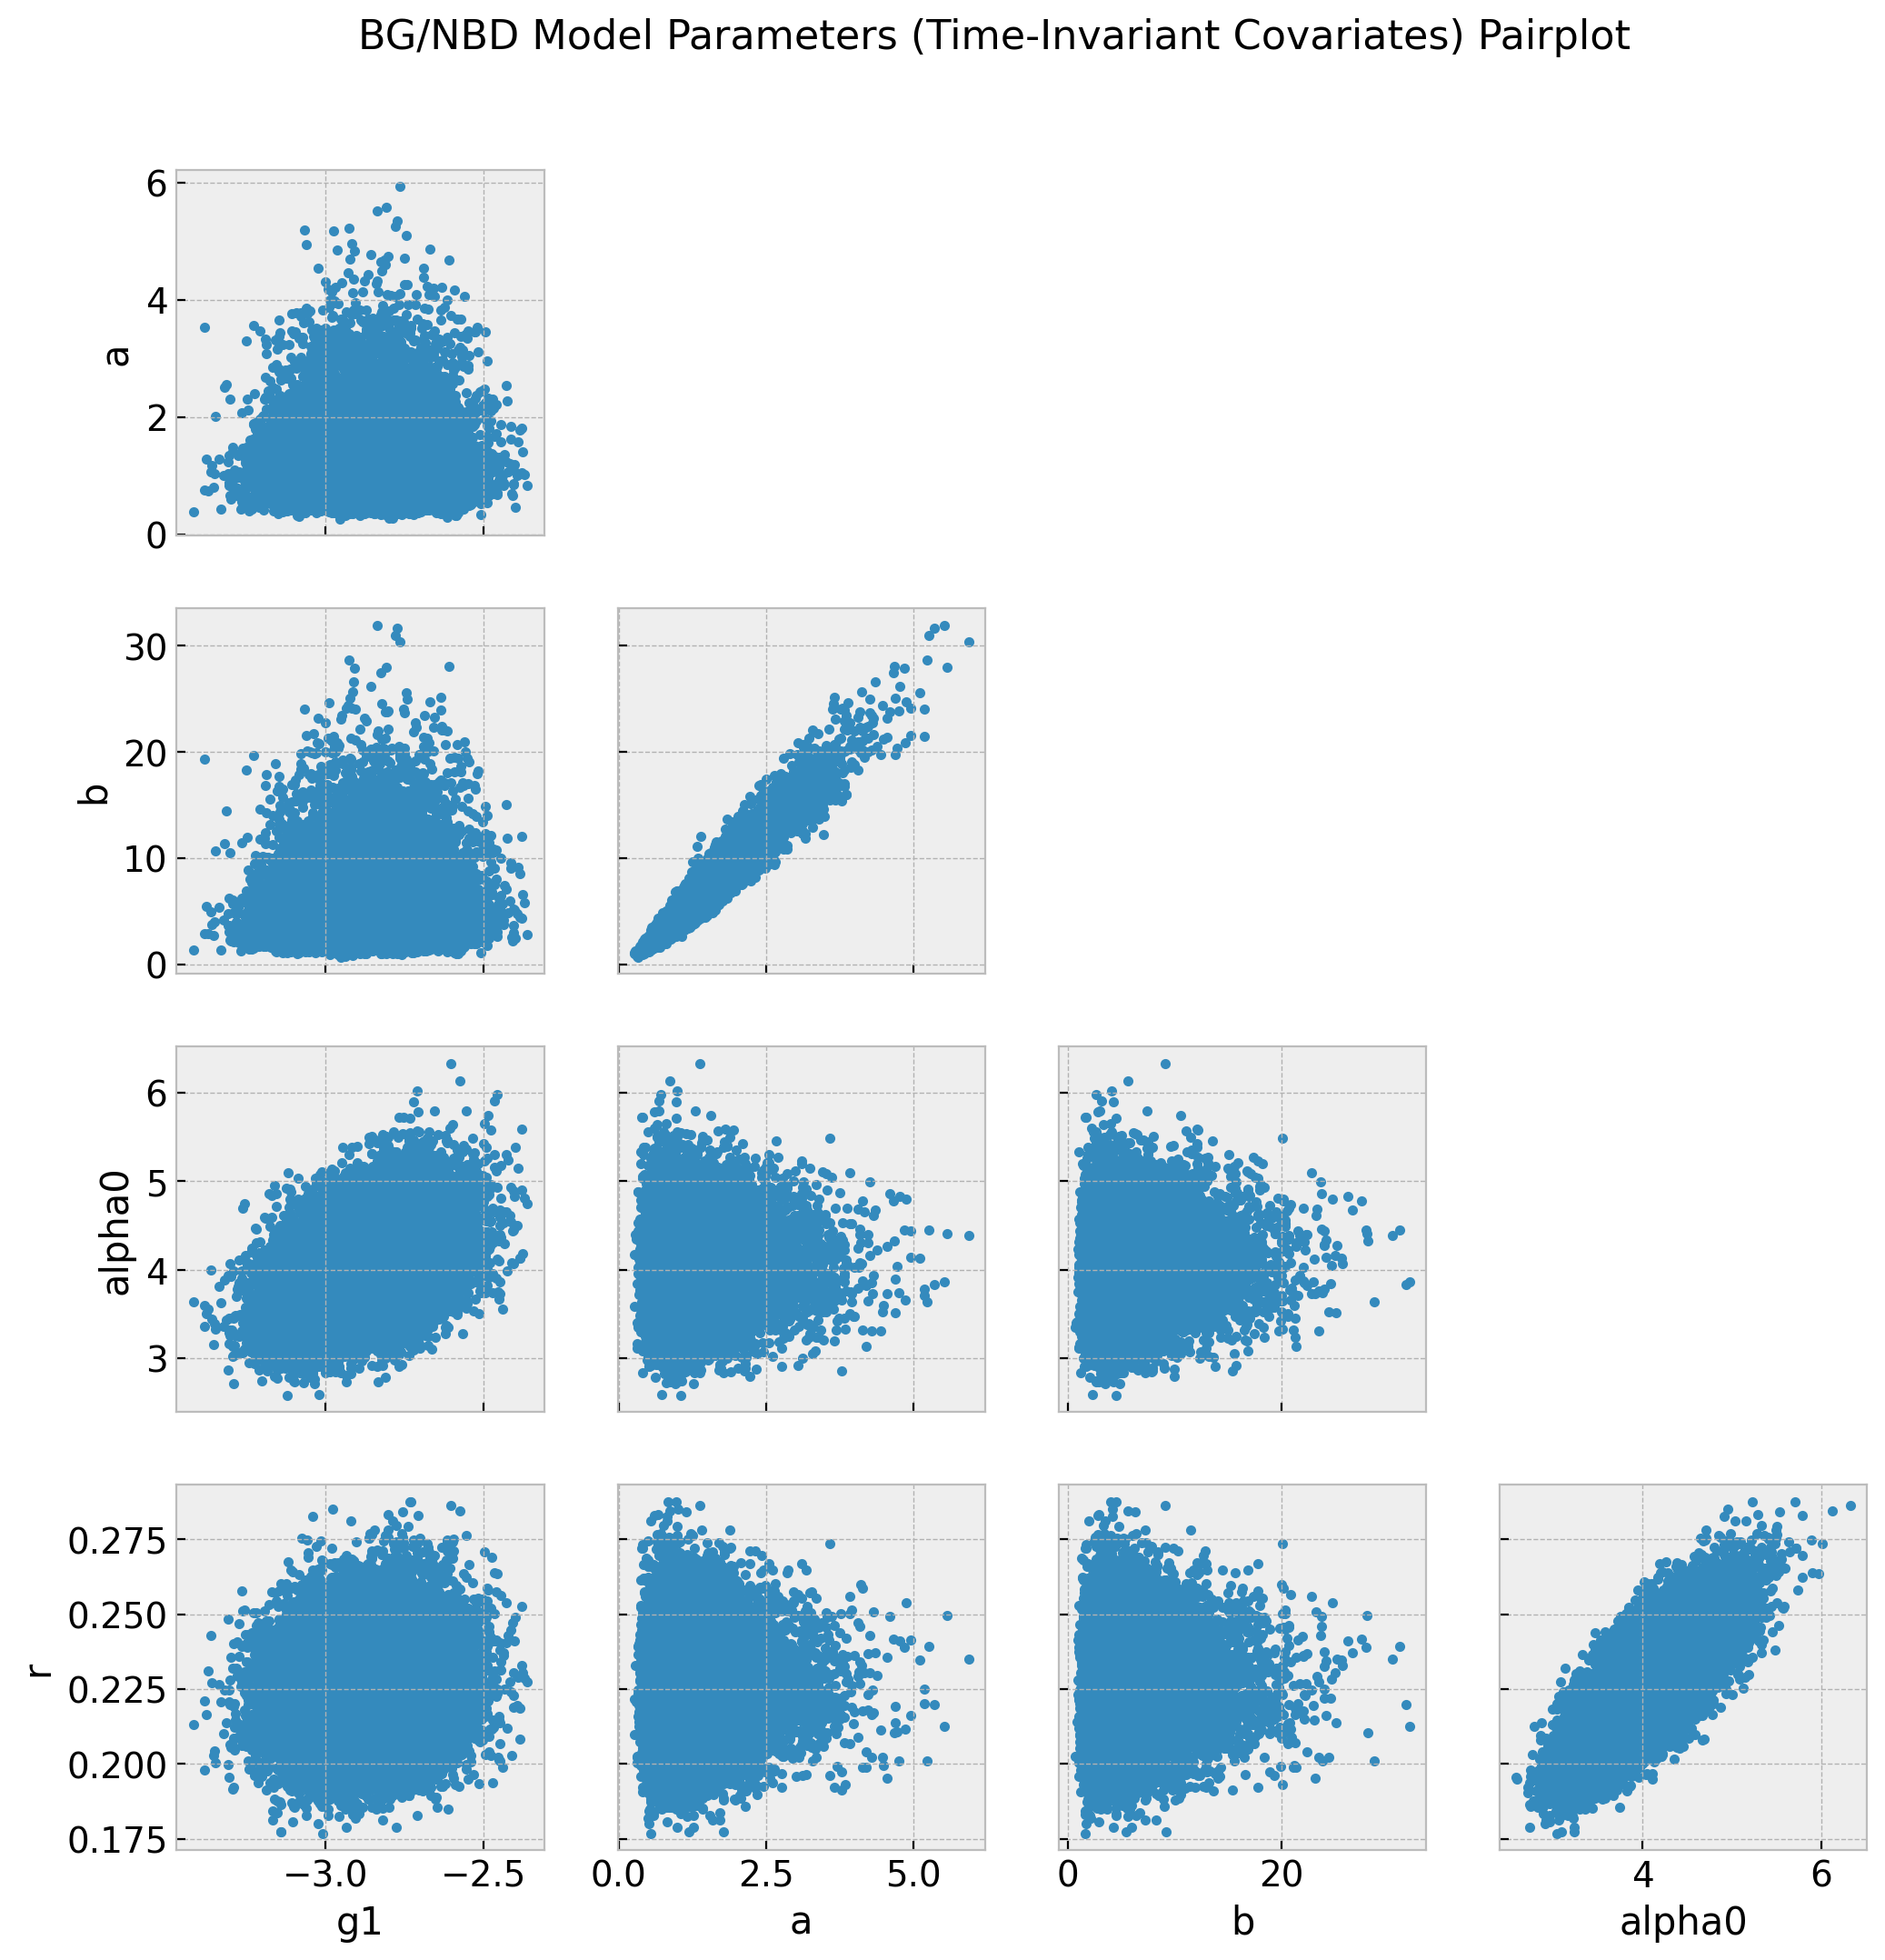

In [30]:
axes = az.plot_pair(data=trace_cov, var_names=["~alpha"], figsize=(12, 12))
fig = axes[0][0].get_figure()
fig.suptitle("BG/NBD Model Parameters (Time-Invariant Covariates) Pairplot", y=0.95, fontsize=16);

Finally, let us see the two different values (for $z=0$ and $z=1$) of the `alpha` parameter.

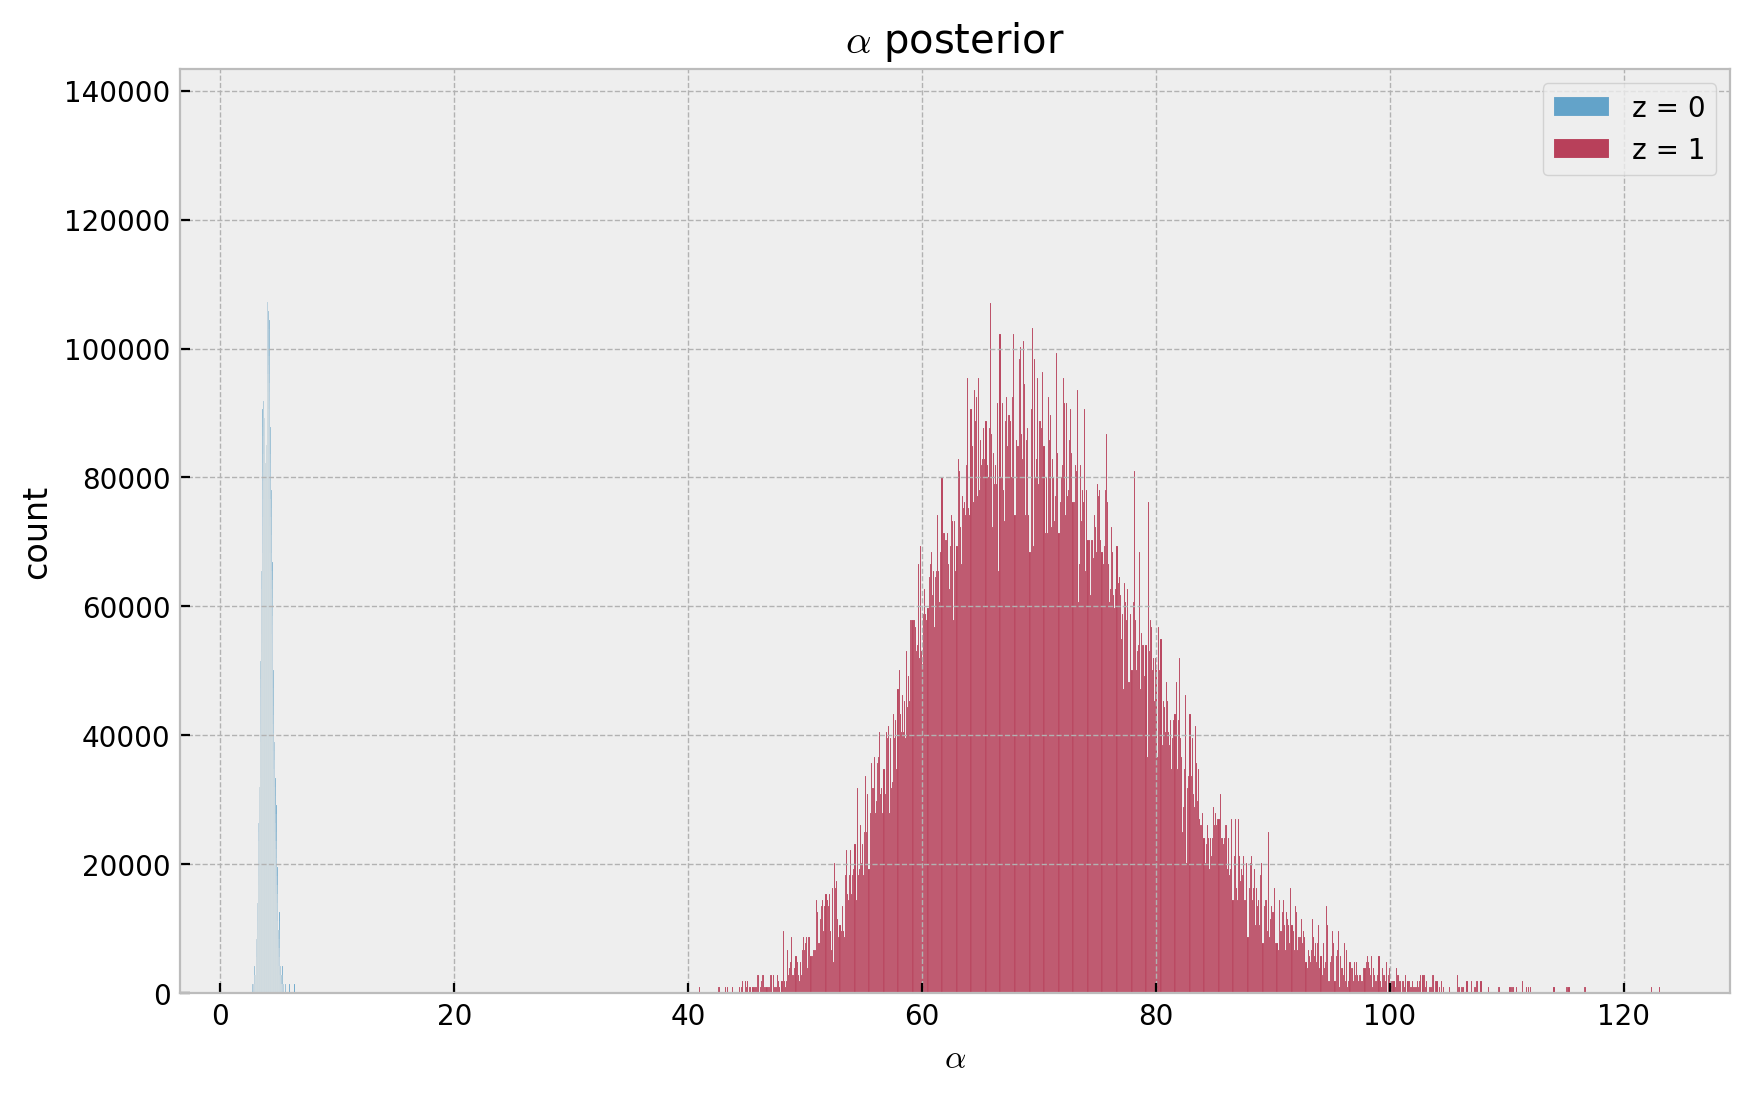

In [31]:
fig, ax = plt.subplots()
sns.histplot(
    x=trace_cov.posterior["alpha"][:, :, z == 0].to_numpy().flatten(),
    color="C0",
    label=r"z = 0",
    ax=ax,
)
sns.histplot(
    x=trace_cov.posterior["alpha"][:, :, z == 1].to_numpy().flatten(),
    color="C1",
    label=r"z = 1",
    ax=ax,
)
ax.legend(loc="upper right")
ax.set(title=r"$\alpha$ posterior", xlabel=r"$\alpha$", ylabel="count");

- Recall $\lambda \sim \text{Gamma}(r, \alpha)$, which has expected value $r/\alpha$.
- Hence, as $g_1 < 0$,  then $\alpha(z=1) > \alpha(z=0)$ which is consistent with the data generation process where $z = 1$ implied a lower frequency.

## Bayesian Model: Hierarchical Model

In this final section we outline how to set up a hierarchical model. This is relevant when you want to model each user cohort separately. For example, you might want to model the purchasing behavior of users who joined the platform in April, May, June, etc. separately. This is useful because the purchasing behavior of users who joined the platform in April might be different from the purchasing behavior of users who joined the platform in June. However, they are not independent of each other hence we would like to pool information across cohorts. Moreover, this comes very handy when trying to make predictions for very young cohorts (cold start problem).

In this example we artificially create $4$ cohorts:

In [32]:
groups = ["g1", "g2", "g3", "g4"]

data_df["group"] = rng.choice(a=groups, p=[0.45, 0.35, 0.15, 0.05], size=n_obs)

data_df["group"].value_counts()

g1    1065
g2     815
g3     353
g4     124
Name: group, dtype: int64

For the sake of comparison, let's fit the `lifetimes` model each cohort.

In [33]:
group_summaries = []

for g, group_df in data_df.groupby("group"):
    # set data
    x_g = group_df["frequency"].to_numpy()
    t_x_g = group_df["recency"].to_numpy()
    T_g = group_df["T"].to_numpy()
    x_zero_g = int_vec(x_g > 0)
    # fit model
    bgf_g = BetaGeoFitter()
    bgf_g.fit(frequency=x_g, recency=t_x_g, T=T_g)
    group_summary_df = (
        bgf_g.summary.assign(group=g)
        .reset_index(drop=False)
        .rename(columns={"index": "parameter"})
    )
    group_summaries.append(group_summary_df)

group_summaries = pd.concat(group_summaries, axis=0)

In [34]:
group_summaries

parameter 
 coef 
 se(coef) 
 lower 95% bound 
 upper 95% bound 
 group 
 
 
 
 
 0 
 r 
 0.230703 
 0.017721 
 0.195971 
 0.265436 
 g1 
 
 
 1 
 alpha 
 4.312733 
 0.547934 
 3.238784 
 5.386683 
 g1 
 
 
 2 
 a 
 0.989651 
 0.415796 
 0.174691 
 1.804611 
 g1 
 
 
 3 
 b 
 3.291437 
 1.724476 
 -0.088537 
 6.671411 
 g1 
 
 
 0 
 r 
 0.259025 
 0.022853 
 0.214233 
 0.303816 
 g2 
 
 
 1 
 alpha 
 4.754671 
 0.684570 
 3.412914 
 6.096428 
 g2 
 
 
 2 
 a 
 0.564523 
 0.185246 
 0.201440 
 0.927606 
 g2 
 
 
 3 
 b 
 1.457592 
 0.586177 
 0.308686 
 2.606499 
 g2 
 
 
 0 
 r 
 0.271790 
 0.037150 
 0.198976 
 0.344603 
 g3 
 
 
 1 
 alpha 
 4.781757 
 1.090382 
 2.644607 
 6.918906 
 g3 
 
 
 2 
 a 
 2.327516 
 3.830876 
 -5.181000 
 9.836032 
 g3 
 
 
 3 
 b 
 10.054263 
 18.778442 
 -26.751482 
 46.860009 
 g3 
 
 
 0 
 r 
 0.180750 
 0.039690 
 0.102958 
 0.258542 
 g4 
 
 
 1 
 alpha 
 2.806377 
 1.095709 
 0.658788 
 4.953967 
 g4 
 
 
 2 
 a 
 0.821841 
 0.646647 
 -0.445587 
 2.089269 
 g4 
 
 
 3 
 b 
 2.217292 
 2.128679 
 -1.954919 
 6.389502 
 g4

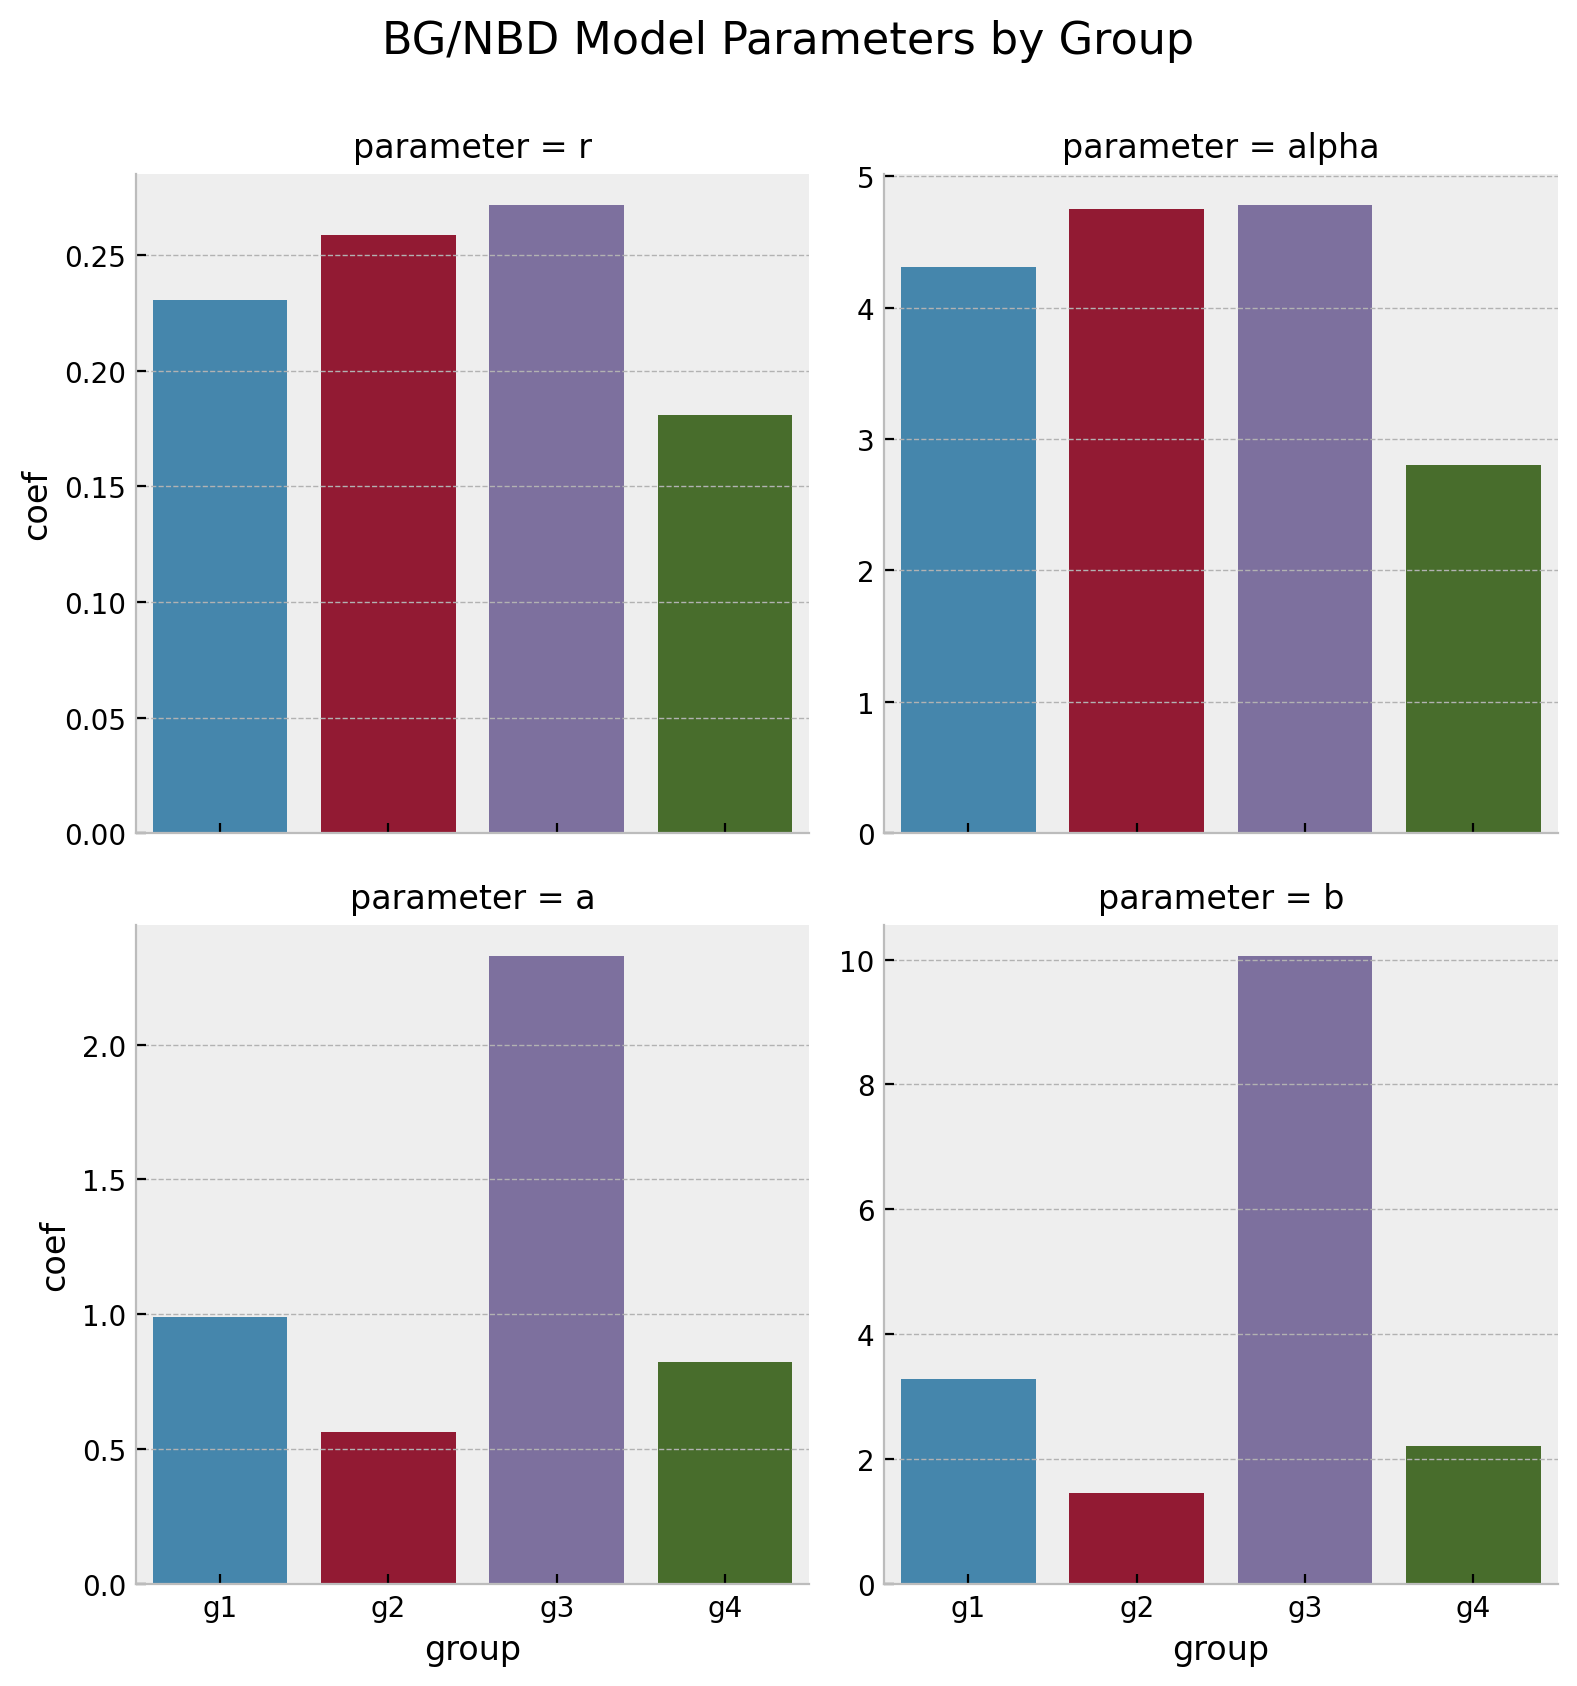

In [35]:
g = sns.catplot(
    data=group_summaries,
    x="group",
    y="coef",
    col="parameter",
    col_wrap=2,
    kind="bar",
    sharex=True,
    sharey=False,
    height=4,
)

g.fig.suptitle("BG/NBD Model Parameters by Group", y=1.05, fontsize=16);

Now we specify the hierarchical model.

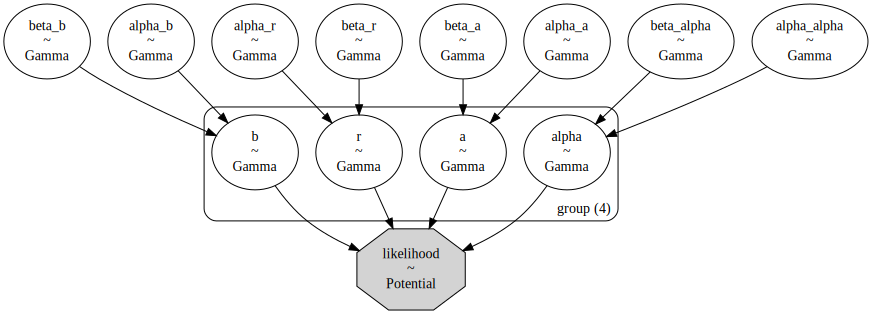

In [36]:
group_idx, groups = data_df["group"].factorize(sort=True)

coords = {
    "group_idx": group_idx,
    "group": groups,
}

with pm.Model(coords=coords) as model_h:

    # hyper-priors
    alpha_a = pm.Gamma(name="alpha_a", alpha=1, beta=1)
    beta_a = pm.Gamma(name="beta_a", alpha=1, beta=1)
    alpha_b = pm.Gamma(name="alpha_b", alpha=1, beta=1)
    beta_b = pm.Gamma(name="beta_b", alpha=1, beta=1)

    alpha_alpha = pm.Gamma(name="alpha_alpha", alpha=5, beta=2)
    beta_alpha = pm.Gamma(name="beta_alpha", alpha=2, beta=2)
    alpha_r = pm.Gamma(name="alpha_r", alpha=1, beta=1)
    beta_r = pm.Gamma(name="beta_r", alpha=1, beta=1)

    # priors
    a_group= pm.Gamma(name="a", alpha=alpha_a, beta=beta_a, dims="group")
    b_group = pm.Gamma(name="b", alpha=alpha_b, beta=beta_b,  dims="group")

    alpha_group = pm.Gamma(name="alpha", alpha=alpha_alpha, beta=beta_alpha, dims="group")
    r_group = pm.Gamma(name="r", alpha=alpha_r, beta=beta_r, dims="group")

    # cohort-specific parameters
    a = a_group[group_idx]
    b = b_group[group_idx]
    alpha = alpha_group[group_idx]
    r = r_group[group_idx]

    # log-likelihood
    def logp(x, t_x, T, x_zero):
        a1 = at.gammaln(r + x) - at.gammaln(r) + r * at.log(alpha)
        a2 = at.gammaln(a + b) + at.gammaln(b + x) - at.gammaln(b) - at.gammaln(a + b + x)
        a3 = -(r + x) * at.log(alpha + T)
        a4 =  at.log(a) - at.log(b + at.maximum(x, 1) - 1) - (r + x) * at.log(t_x + alpha)
        max_a3_a4 = at.maximum(a3, a4)
        ll_1 = a1 + a2 
        ll_2 = at.log(at.exp(a3 - max_a3_a4) + at.exp(a4 - max_a3_a4) * pm.math.switch(x_zero, 1, 0)) + max_a3_a4
        return at.sum(ll_1 + ll_2)

    likelihood = pm.Potential(name="likelihood", var=logp(x, t_x, T, x_zero))


pm.model_to_graphviz(model=model_h)

In [37]:
with model_h:
    trace_h = pm.sampling_jax.sample_numpyro_nuts(
        tune=3000,
        draws=6000,
        chains=4,
        target_accept=0.95,
    )

Compiling...
Compilation time =  0:00:05.729829
Sampling...


  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

Sampling time =  0:05:56.463690
Transforming variables...
Transformation time =  0:00:00.042853


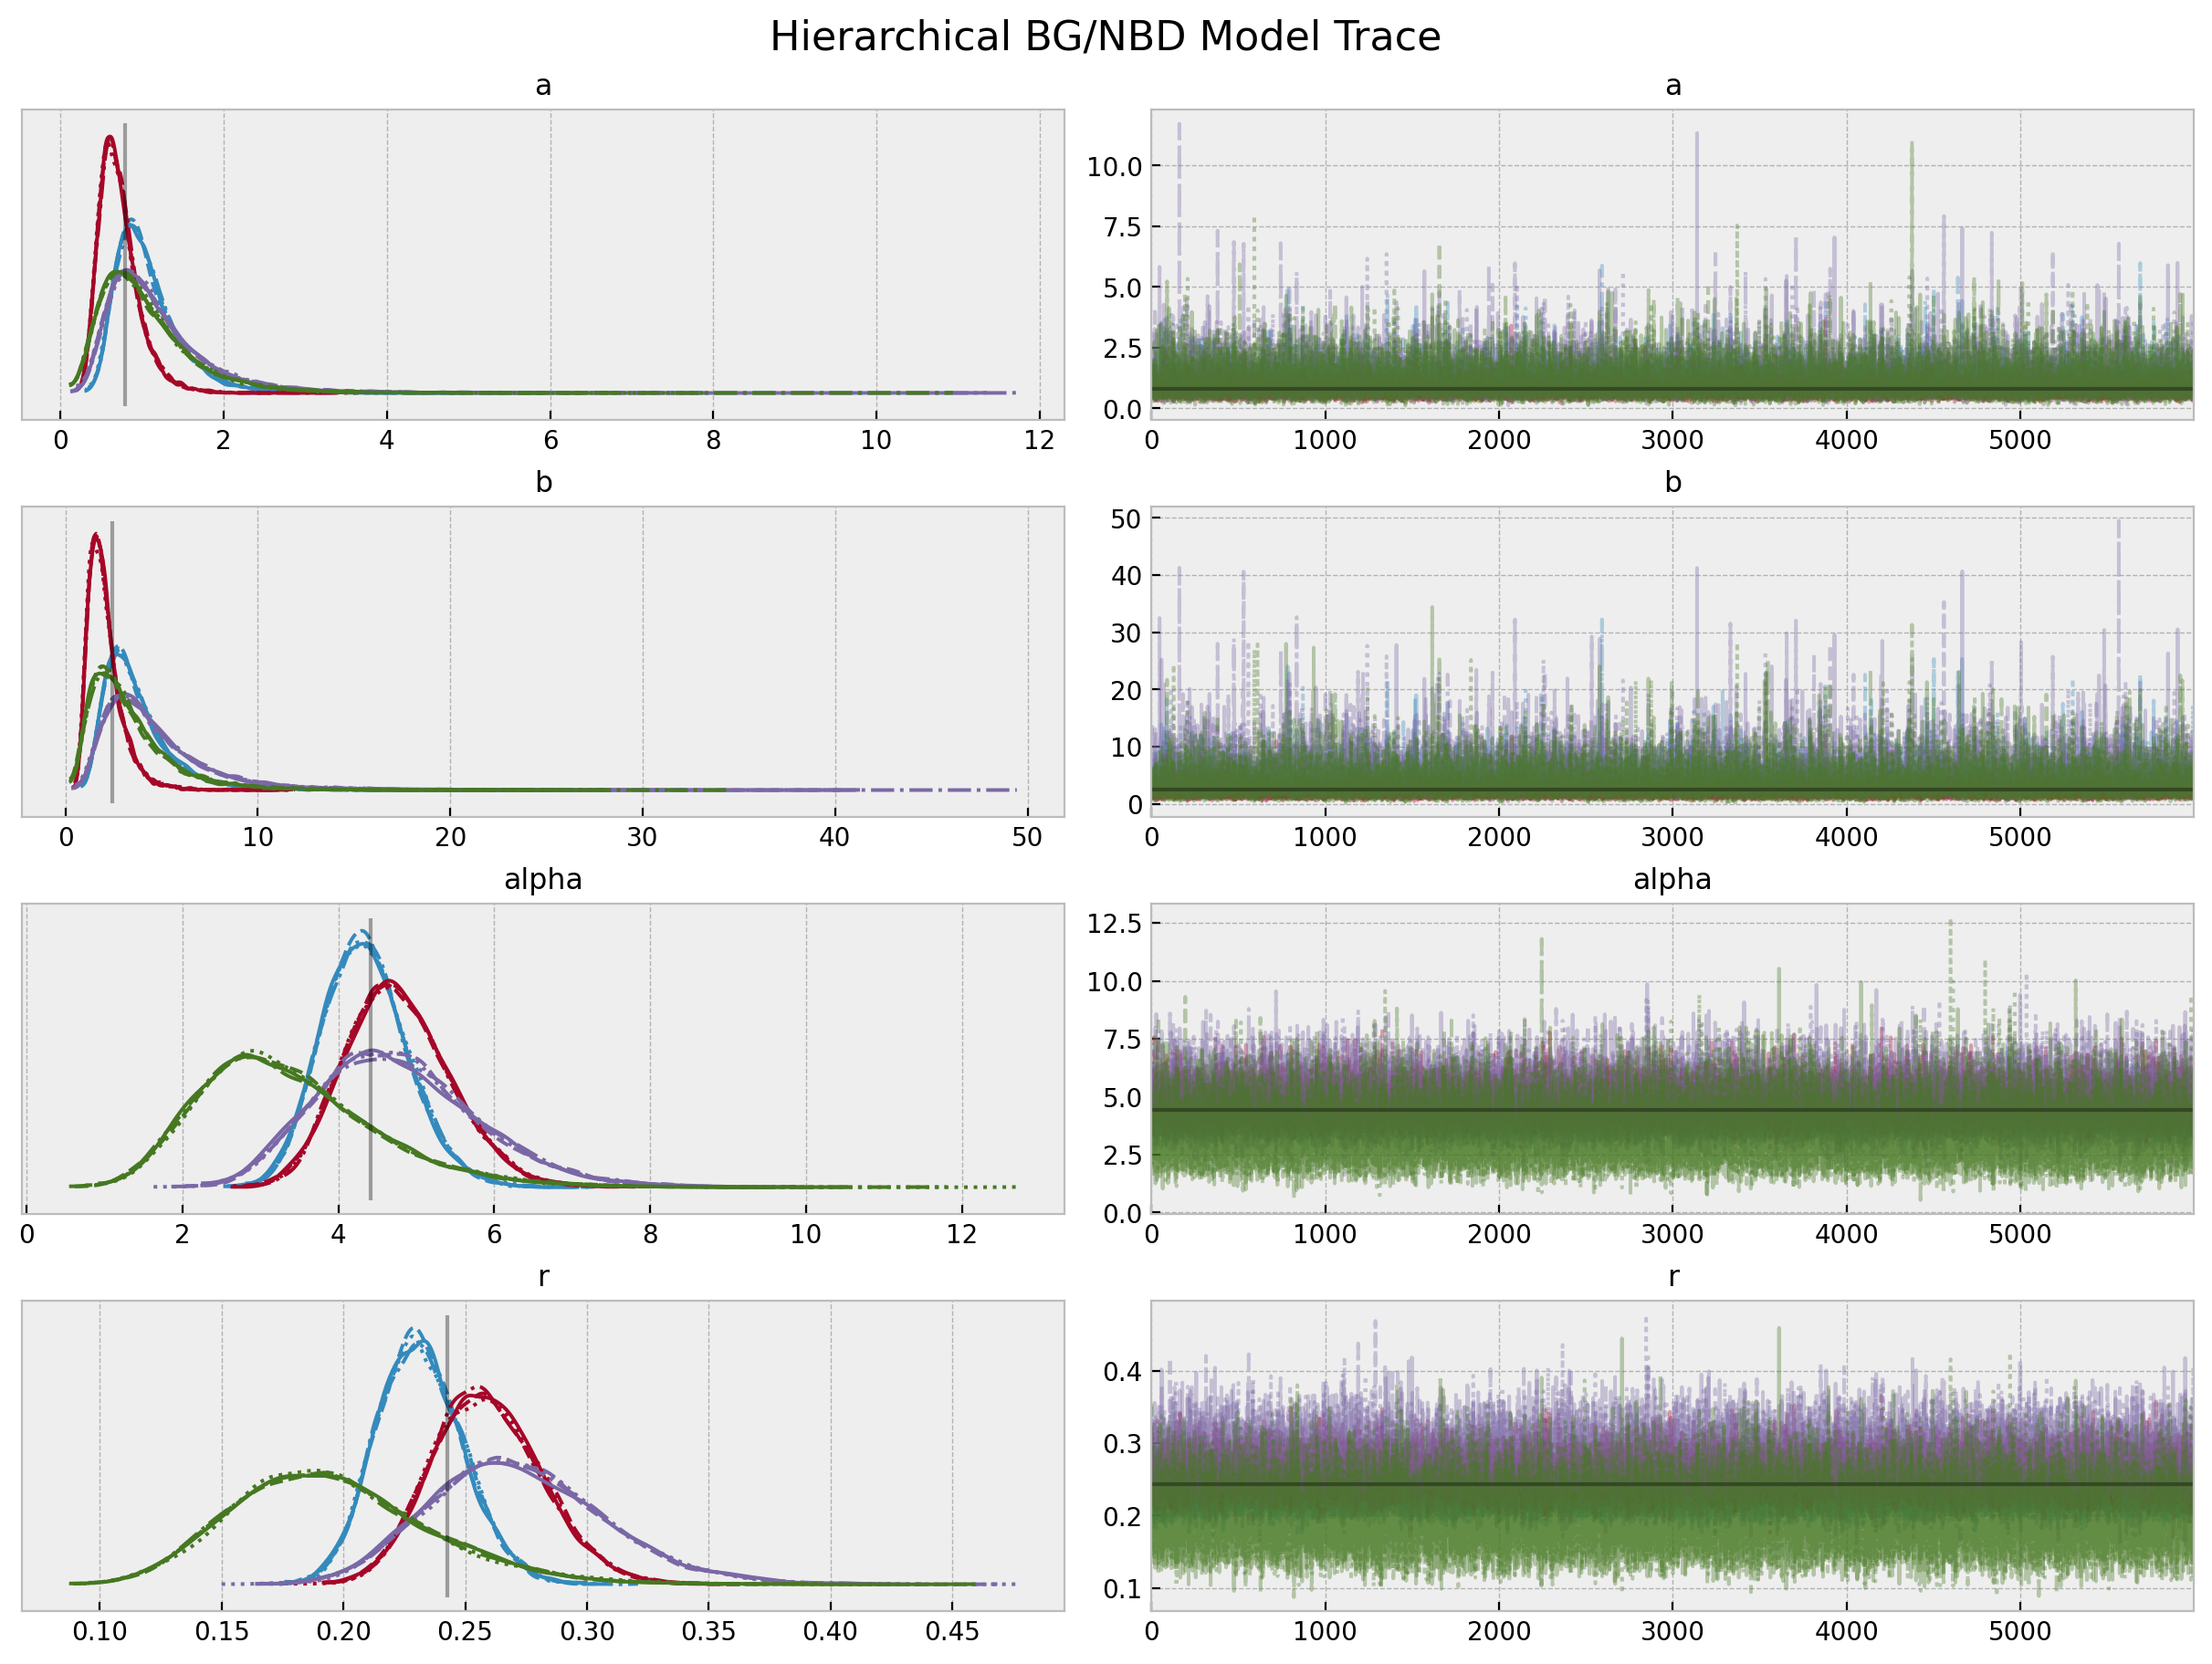

In [38]:
axes = az.plot_trace(
    data=trace_h,
    var_names=["a", "b", "alpha", "r"],
    lines=[(k, {}, [v]) for k, v in bgf.summary["coef"].items()],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Hierarchical BG/NBD Model Trace", fontsize=16);

Let's look into the summary:

In [39]:
az.summary(data=trace_h)

mean 
 sd 
 hdi_3% 
 hdi_97% 
 mcse_mean 
 mcse_sd 
 ess_bulk 
 ess_tail 
 r_hat 
 
 
 
 
 alpha_a 
 1.686 
 0.869 
 0.345 
 3.308 
 0.006 
 0.004 
 19833.0 
 15505.0 
 1.0 
 
 
 beta_a 
 1.610 
 0.964 
 0.113 
 3.346 
 0.007 
 0.005 
 18769.0 
 13989.0 
 1.0 
 
 
 alpha_b 
 2.158 
 1.177 
 0.376 
 4.334 
 0.008 
 0.006 
 19374.0 
 14736.0 
 1.0 
 
 
 beta_b 
 0.727 
 0.492 
 0.035 
 1.612 
 0.004 
 0.003 
 14664.0 
 14192.0 
 1.0 
 
 
 alpha_alpha 
 3.356 
 1.157 
 1.426 
 5.586 
 0.007 
 0.005 
 24029.0 
 16938.0 
 1.0 
 
 
 beta_alpha 
 0.806 
 0.326 
 0.253 
 1.424 
 0.002 
 0.001 
 23975.0 
 16880.0 
 1.0 
 
 
 alpha_r 
 0.985 
 0.490 
 0.203 
 1.884 
 0.003 
 0.002 
 24218.0 
 15896.0 
 1.0 
 
 
 beta_r 
 2.523 
 1.499 
 0.208 
 5.237 
 0.009 
 0.007 
 24994.0 
 15206.0 
 1.0 
 
 
 a[g1] 
 1.073 
 0.427 
 0.444 
 1.820 
 0.004 
 0.003 
 17394.0 
 13936.0 
 1.0 
 
 
 a[g2] 
 0.719 
 0.252 
 0.323 
 1.185 
 0.002 
 0.001 
 21337.0 
 16544.0 
 1.0 
 
 
 a[g3] 
 1.171 
 0.653 
 0.288 
 2.296 
 0.005 
 0.004 
 16840.0 
 15148.0 
 1.0 
 
 
 a[g4] 
 1.053 
 0.604 
 0.196 
 2.121 
 0.005 
 0.003 
 17540.0 
 17338.0 
 1.0 
 
 
 b[g1] 
 3.732 
 1.897 
 1.223 
 7.015 
 0.016 
 0.012 
 17363.0 
 13250.0 
 1.0 
 
 
 b[g2] 
 2.046 
 0.922 
 0.733 
 3.723 
 0.007 
 0.005 
 21084.0 
 16081.0 
 1.0 
 
 
 b[g3] 
 4.662 
 3.055 
 0.865 
 9.795 
 0.026 
 0.019 
 16142.0 
 14831.0 
 1.0 
 
 
 b[g4] 
 3.354 
 2.367 
 0.464 
 7.385 
 0.019 
 0.013 
 17720.0 
 16726.0 
 1.0 
 
 
 alpha[g1] 
 4.348 
 0.547 
 3.375 
 5.414 
 0.003 
 0.002 
 25730.0 
 19111.0 
 1.0 
 
 
 alpha[g2] 
 4.770 
 0.675 
 3.571 
 6.068 
 0.004 
 0.003 
 26851.0 
 19591.0 
 1.0 
 
 
 alpha[g3] 
 4.764 
 1.027 
 2.895 
 6.659 
 0.006 
 0.005 
 25637.0 
 18370.0 
 1.0 
 
 
 alpha[g4] 
 3.352 
 1.132 
 1.402 
 5.454 
 0.007 
 0.005 
 25535.0 
 19124.0 
 1.0 
 
 
 r[g1] 
 0.232 
 0.018 
 0.197 
 0.264 
 0.000 
 0.000 
 26531.0 
 19190.0 
 1.0 
 
 
 r[g2] 
 0.259 
 0.023 
 0.218 
 0.303 
 0.000 
 0.000 
 26711.0 
 20014.0 
 1.0 
 
 
 r[g3] 
 0.272 
 0.036 
 0.205 
 0.338 
 0.000 
 0.000 
 25764.0 
 18768.0 
 1.0 
 
 
 r[g4] 
 0.195 
 0.040 
 0.123 
 0.272 
 0.000 
 0.000 
 25393.0 
 19000.0 
 1.0

Finally, let's compare the parameter of the `lifetimes` model with the predictions of the hierarchical model.

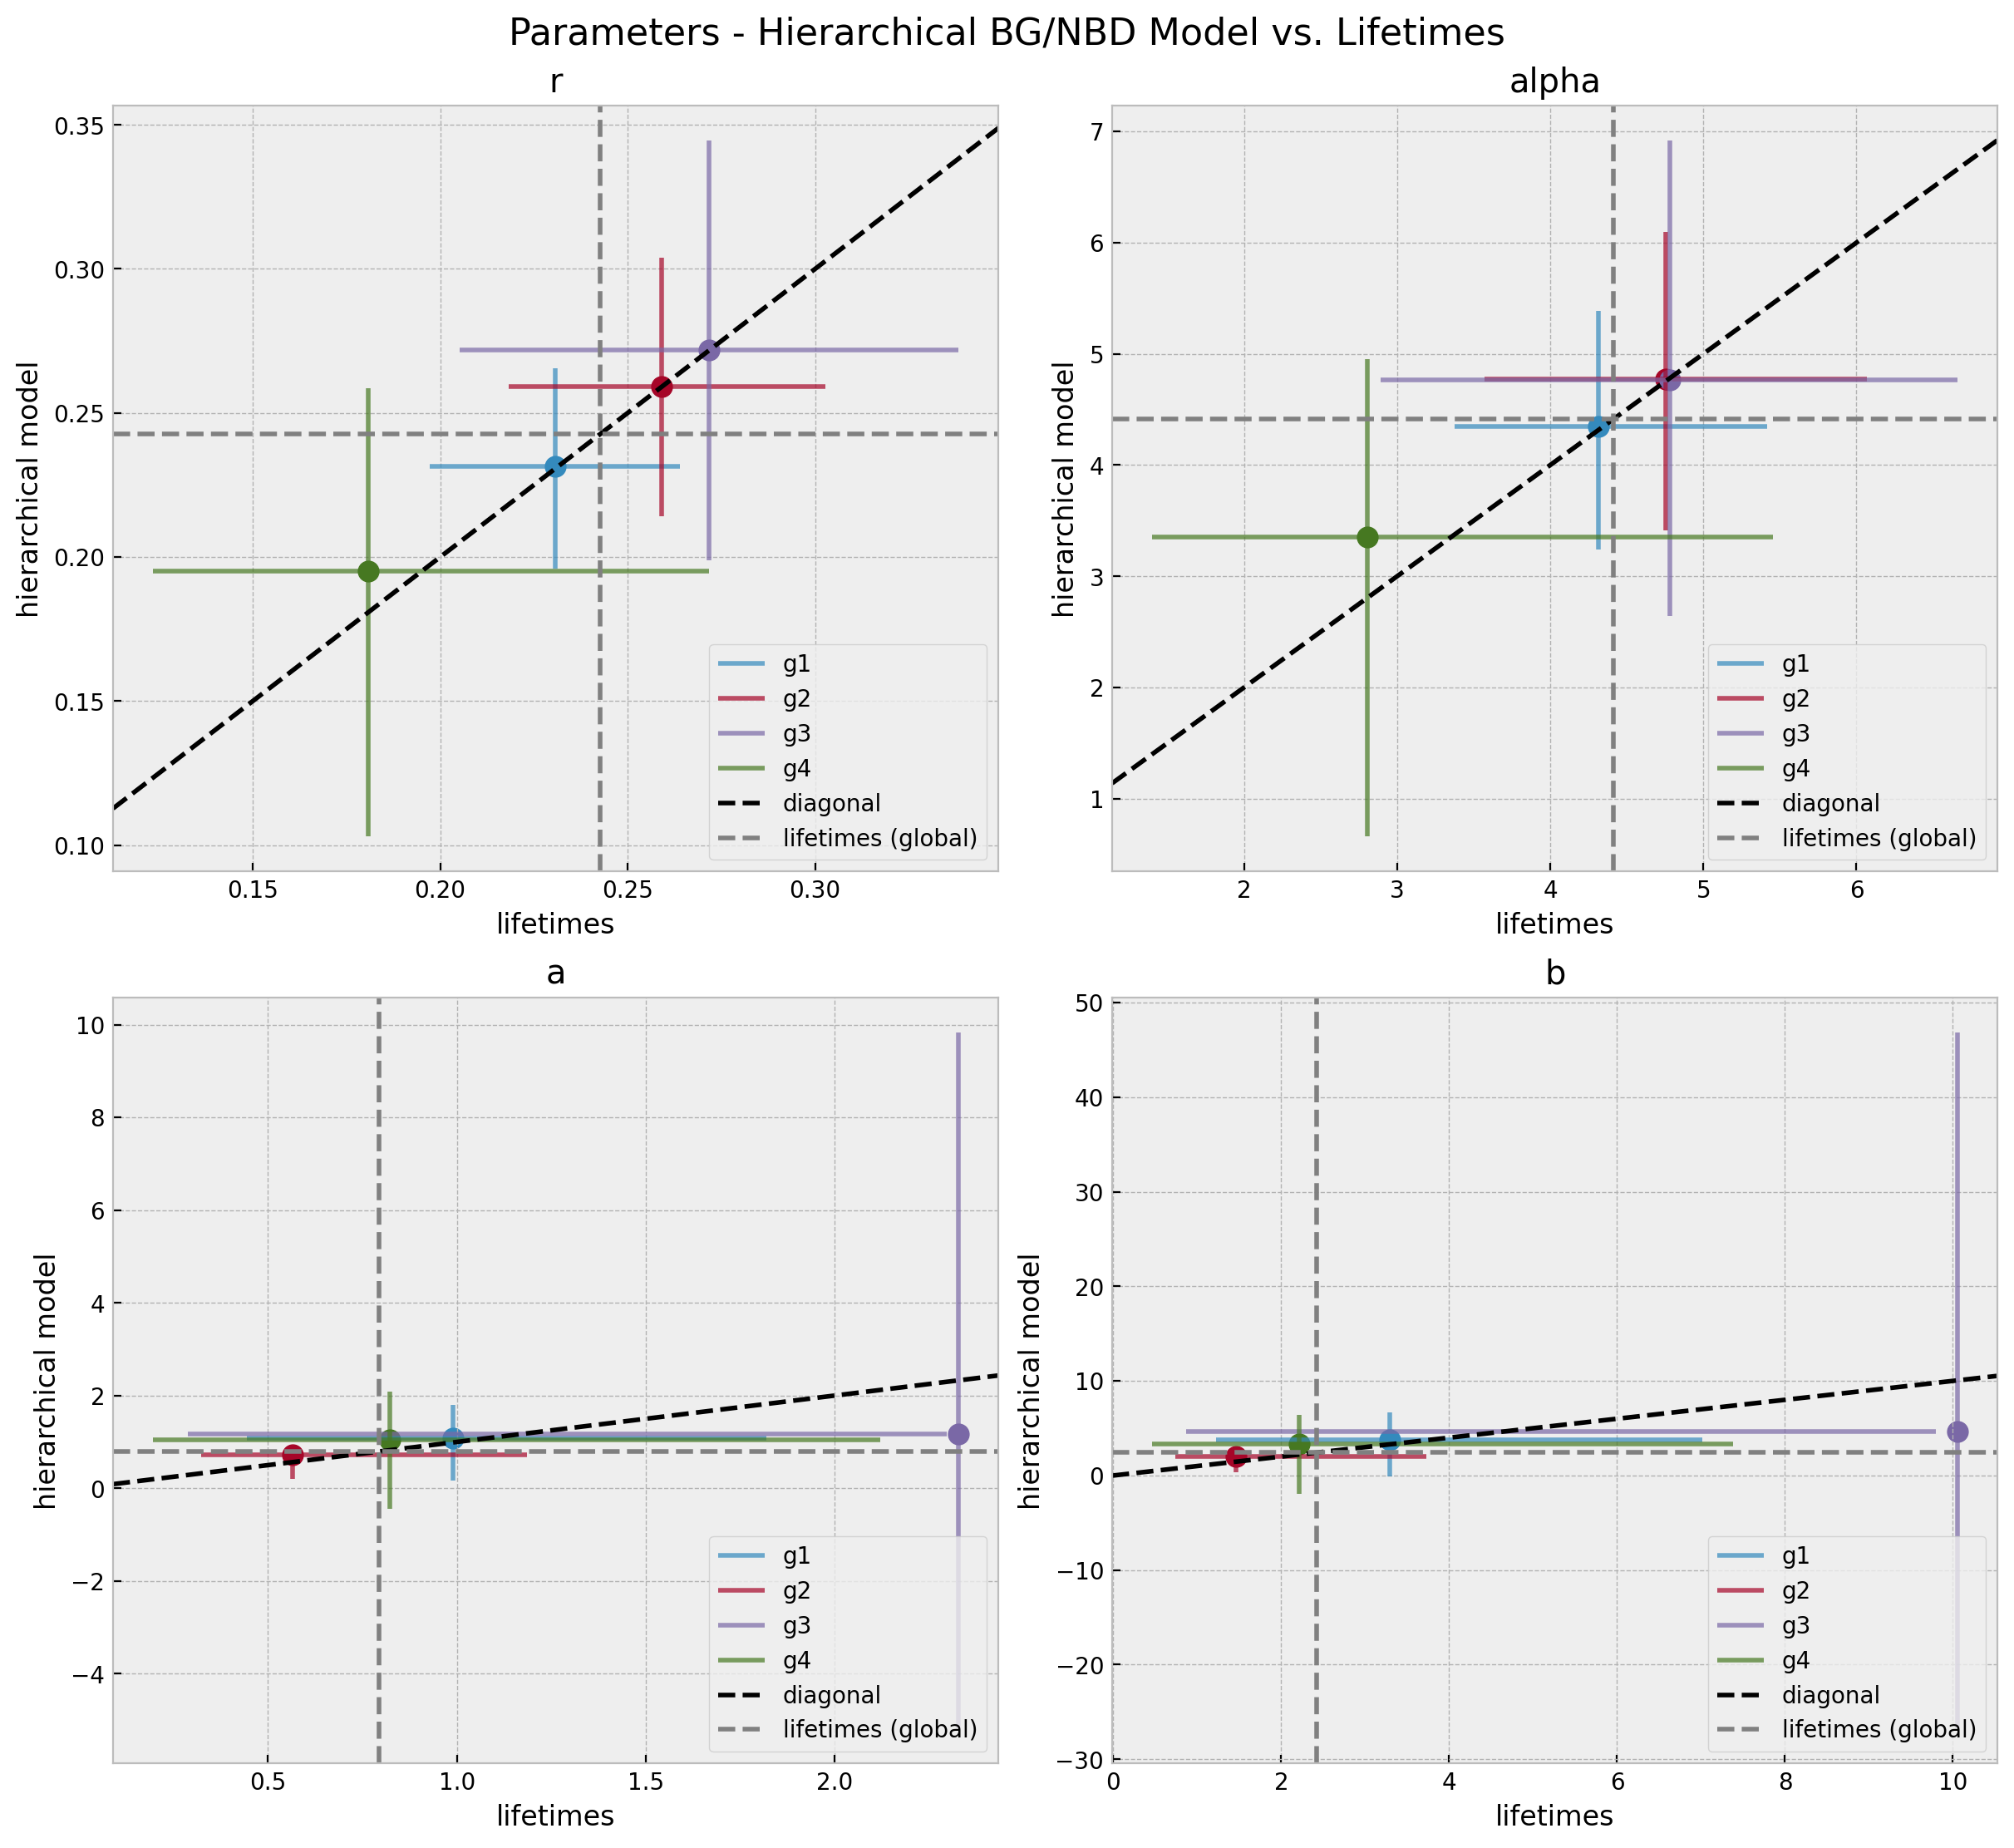

In [40]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 11), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, parameter in enumerate(["r", "alpha", "a", "b"]):
    # compute summary per parameter
    parameter_hdi = az.hdi(trace_h.posterior[parameter])[parameter].to_numpy()
    parameter_mean = (
        trace_h.posterior[parameter].stack(sample=("chain", "draw")).mean(axis=1)
    )

    model_h_parameter_df = pd.DataFrame(
        data=parameter_hdi, columns=["lower", "upper"]
    ).assign(group=groups, mean=parameter_mean)

    lifetimes_parameter_df = group_summaries.query("parameter == @parameter")

    parameter_df = model_h_parameter_df.merge(lifetimes_parameter_df, on="group")

    # plot
    ax = axes[i]

    for j, row in parameter_df.iterrows():

        ax.vlines(
            x=row["coef"],
            ymin=row["lower 95% bound"],
            ymax=row["upper 95% bound"],
            color=f"C{j}",
            label=row["group"],
            alpha=0.7,
        )
        ax.hlines(
            y=row["mean"],
            xmin=row["lower"],
            xmax=row["upper"],
            color=f"C{j}",
            alpha=0.7,
        )

        ax.scatter(x=row["coef"], y=row["mean"], color=f"C{j}", s=80)

    ax.axline(
        xy1=(row["mean"], row["mean"]),
        slope=1,
        color="black",
        linestyle="--",
        label="diagonal",
    )
    ax.axvline(
        x=bgf.summary.reset_index(drop=False)
        .query("index == @parameter")["coef"]
        .item(),
        color="gray",
        linestyle="--",
        label="lifetimes (global)",
    )
    ax.axhline(
        y=bgf.summary.reset_index(drop=False)
        .query("index == @parameter")["coef"]
        .item(),
        color="gray",
        linestyle="--",
    )
    ax.legend(loc="lower right")

    ax.set(title=parameter, xlabel="lifetimes", ylabel="hierarchical model")

fig.suptitle("Parameters - Hierarchical BG/NBD Model vs. Lifetimes", fontsize=16);

Here we can see the *shrinkage* effect of the hierarchical model. The model parameters are closer to the global estimates (i.e. the estimates of the model without cohorts).